# Learning Kinetics from Time Series Data

This notebook is an implementation of Kinetic Learning created by Zak Costello.

## TODO for Publication

### Code Functionality:
1. Develop a Data Set to simulate the method for testing.
    * [X] Trouble Shoot Data Generation Function to figure out why Integration is failing...
2. [X] Implement Kinetic Model Prediction + Plot Prediction on Experimental Prediction Plots
3. [X] Add RMSE Metrics For Kinetic Model and report

### Code Quality:
1. [X] Rewrite and Simplify Code.
2. [X] Add to Version control.

### Paper Writing:

1. [X] Normalize Axes On Big Simulated Data Plot

3. Update Figures for Each Simulation to Mirror Most Up to Date Version
    * [X] Improve Simulated Figures (Add Legend + Make Target more noticable)
    * [X] Simulated / Simple
    * [X] Simulated / Limonene
    * [X] Experimental / Limonene
    * [X] Experimental / Isopentenol
6. [X] Incorporate Kinetic Model Comparisons into Existing Experimental data set plots (if they are even at all close)

7. [X] Make All plots write out files and save all data generated!

## Ideas for Future:
1. Implement Code in tensor flow (with a better machine learning model...)
2. Expand number of pathway models -- show i can learn simulated data for many pathways
3. Optimize titer using this method directly inferred from data!

# 1. Set Flags For Running Code
Four data sets are supported in this code.  Two are simulated, and two are from experimental data. Change the set_num variable below to choose which data set to fit.

In [1]:
#Choose the data set to run
data_sets = [('simulated','small'),          #Small Canonical Pathway Model with Feedback Inhibition 
             ('simulated','limonene'),        #Large Limonene Model Developed Based on the Literature
             ('experimental','isopentenol'),  #Experimental Isopentenol Pathway Time Series Data
             ('experimental','limonene')]     #Experimental Limonene Pathway Time Series Data

set_num = 1

The Machine Learning Model is determined by these flags.  The features to use can be automatic or manual and the machine learning model can be chosen. Additionally, the random seed can be set.

In [2]:
feature_selection = 'Automatic'   #Manual or Automatic: Manual has hand selected features, Autmatic uses an algorithm
machine_learning_model = 'tpot'   #neural,random_forest(RF)

#Set Random Seed for deterministic Execution
seed = None #If seed is set then output will be deterministic (And results can be cached for faster execution)

#Time Consuming, will be cached for each unique case. (Only Relevant for experimental Limonene Pathway)
run_kinetic_model = True #Allows for comparison between ml model and kinetic model performance

Variables to Set For Simulated Data Sets (How Many Strains and how many training sets needed

In [3]:
#Relevant if Simulated
data_type,pathway = data_sets[set_num]
if data_sets[set_num][0] == 'simulated':
    strain_numbers = [2,10,100]
    training_sets = 20 #Change to support a variable number here (I want to shoot for 10...)
    
    #Strains Needed Calculation
    strains_needed = (max(strain_numbers) + 1)*training_sets + 1 + 2000
    print(strains_needed)
    
    #Calculation of training_size values
    train_sizes = []
    for strain_number in strain_numbers:
        train_size = (strain_number + 1) * training_sets / (strains_needed - 1)
        train_sizes.append(train_size)
    print(train_sizes)
    
    print([int((strains_needed-1)*size/training_sets)-1 for size in train_sizes])
    #Strains Required

    training_strains = strains_needed
    test_strains = 1200

elif data_type == 'experimental':
    pass


#Plotting Options (If set true more extensive plots are created for troubleshooting purposes)
Plot_Data = False

4021
[0.014925373134328358, 0.05472636815920398, 0.5024875621890548]
[2, 10, 100]


# 2. Import Modules & Setup
Importing all required modules and helper functions

In [4]:
%matplotlib inline
from plot import *
from helper import *
from IPython.display import display
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import differential_evolution
import math
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')

# 3. Load & Format Data into DataFrame

In [5]:
if data_type == 'simulated':
    if pathway == 'limonene':
        file_name = 'data/Fulld10000n0.csv'
        y0 = [1e-5]*10
        timeKey = 'Time'
        df = pd.read_csv(file_name)
        df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

        strains = df.index.get_level_values(0).unique()
        sample = random.sample(list(strains),training_strains+test_strains)

        #create test df
        test_df = df.loc[(sample[0:test_strains],slice(None))]

        #create the training df
        df = df.loc[(sample[test_strains:],slice(None))]

        features = ['AtoB','HMGR','HMGS','MK','PMK','PMD','Idi','GPPS','LS']
        targets=['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']
        specific_features = {'Acetyl-CoA':      ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR'],
                             'Acetoacetyl-CoA': ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMG-CoA'],
                             'HMG-CoA':         ['Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMGS','HMG-CoA'],
                             'Mev':             ['Acetyl-CoA','Acetoacetyl-CoA','HMGS','HMG-CoA','MK','Mev','GPP','MevP'],
                             'MevP':            ['MK','Mev','GPP','MevP','PMK'],
                             'MevPP':           ['PMK','MevP','PMD','MevPP','Mev'],
                             'IPP':             ['PMD','MevPP','MevP','Mev','Idi','IPP','GPPS','DMAPP'],
                             'DMAPP':           ['Idi','IPP','GPPS','DMAPP'],
                             'GPP':             ['GPPS','IPP','DMAPP','GPP','LS'],
                             'Limonene':        ['LS','GPP']}

        #Create TSDF for training strains
        tsdf = generateTSDataSet(df,features,targets)
        
        #Create Validation TSDF to test the models predictive power
        test_tsdf = generateTSDataSet(test_df,features,targets)
        display(test_tsdf)
        
    elif pathway=='small':
        file_name = 'data/SmallKineticsd30000n0.csv'
        y0 = [0.2]*3
        timeKey = 'Time'
        df = pd.read_csv(file_name)
        df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

        strains = df.index.get_level_values(0).unique()
        sample = random.sample(list(strains),training_strains+test_strains)

        #create test df
        test_df = df.loc[(sample[0:test_strains],slice(None))]

        #create the training df
        df = df.loc[(sample[test_strains:],slice(None))]

        features = ['e0','e1']
        targets=['s0','s1','s2']
        specific_features = {'s0': ['e0','e1','s0','s1','s2'],
                             's1': ['e0','e1','s0','s1','s2'],
                             's2': ['e0','e1','s0','s1','s2']}

        tsdf = generateTSDataSet(df,features,targets)
    
elif data_type == 'experimental':
    if pathway == 'limonene':
        #Parameters that Can Be Set:
        strains = ['L1','L2','L3']
        training_strains = ['L1','L3']
        test_strains = ['L2']

        #Define Machine Learning Targets & Features To Use

        targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Limonene g/L']
        features = ['OD600','ATP (uM)','AtoB','Limonene Synthase','HMGR','HMGS','MK','PMK','PMD','GPP (uM)',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

        specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','Limonene Synthase','Limonene g/L'],
                             'Limonene g/L':['OD600','ATP (uM)','Limonene Synthase','Limonene g/L','GPP (uM)']}

    elif pathway == 'isopentenol':
        #Parameters that Can Be Set:
        strains = ['I1','I2','I3']
        training_strains = ['I1','I3']
        test_strains = ['I2']
        
        targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Isopentenol g/L']
        features = ['OD600','ATP (uM)','AtoB','NudB','HMGR','HMGS','MK','PMK','PMD',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

        specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','NudB','Isopentenol g/L'],
                             'Isopentenol g/L':['OD600','ATP (uM)','NudB','Isopentenol g/L','IPP/DMAPP (uM)']}

    
    #Processing Data Files and Creating a Shared Dataframe
    metabolite_file_name = 'data/time_series_metabolomics.csv'
    protein_file_name = 'data/time_series_proteomics.csv'

    mdf = pd.read_csv(metabolite_file_name)
    pdf = pd.read_csv(protein_file_name)

    #Format protein tables
    proteins = ['AtoB','HMGR','HMGS','MK','PMD','PMK','Idi','GPPS','Limonene Synthase','NudB']
    proteins = [('ProteinArea',protein) for protein in proteins]
    columns = ['Strain','Time','Protein','ProteinArea']

    pdf = pdf.loc[pdf['Strain'].isin(strains)]
    pdf = pdf.loc[~pdf['Hour'].isin(['72C'])]
    pdf['Hour'] = pdf['Hour'].convert_objects(convert_numeric=True)

    pdf.rename(columns={'Hour': 'Time'}, inplace=True)    
    display(pdf)
    print(columns)

    pdf = pdf[columns].pivot_table(pdf[columns],index=['Strain','Time'],columns='Protein',aggfunc=np.sum)
    pdf = pdf[proteins]
    pdf.columns = pdf.columns.get_level_values(1)
    
    #Format metabolite tables
    metabolites = ['Acetyl-CoA (uM)','Acetyl-CoA extracellular (uM)',
                   'Acetoacetyl-coA (uM)','Acetoacetyl-CoA extracellular (uM)',
                   'HMG-CoA (uM)','HMG-CoA extracellular (uM)',
                   'Intracellular Mevalonate (uM)','MEVALONATE extracellular (uM)',
                   'Mev-P (uM)','MEV-P extracellular (uM)',
                   'IPP/DMAPP (uM)','IPP/DMAPP extracellular (uM)',
                   'GPP (uM)','GPP extracellular (uM)',
                   'Limonene g/L','ATP (uM)','OD600','NAD (uM)','NADP (uM)',
                   'Acetate g/L','Pyruvate g/L','citrate (uM)','Isopentenol g/L']

    mdf = mdf.loc[mdf['Strain'].isin(strains)]
    
    mdf.rename(columns={'Hour': 'Time'}, inplace=True)
    mdf = mdf[['Strain','Time'] + metabolites].pivot_table(mdf[['Strain','Time'] + metabolites],index=['Strain','Time'],aggfunc=np.sum)
    
    #Extracellular Metabolites (mg/L) | Intracelluar Metabolites (mg/L) |Combined Metabolites (mg/L)

    #Join metabolite and protein tables
    df = pd.concat([pdf, mdf], axis=1)
    test_df = df.loc[(test_strains,slice(None))]
    display(test_df)
    df = df.loc[(training_strains,slice(None))]
    tsdf = generateTSDataSet(df,features,targets)#,n_points=100)

Total Time Series in Data Set:  4021


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Total Time Series in Data Set:  1200


feature                                               \
                 Acetoacetyl-CoA Acetyl-CoA          AtoB     DMAPP       GPP   
Strain Time (h)                                                                 
10     0.000000         0.200124   0.200133  7.162759e+04  0.199999  0.199998   
       0.696970         0.198776   0.208485  6.044323e+05  0.200054  0.200162   
       1.393939         0.197010   0.216387  1.018899e+06  0.200114  0.200333   
       2.090909         0.194825   0.223841  1.315029e+06  0.200179  0.200510   
       2.787879         0.192108   0.230724  1.434891e+06  0.200250  0.200696   
       3.484848         0.189100   0.237293  1.503816e+06  0.200323  0.200885   
       4.181818         0.185884   0.243640  1.557903e+06  0.200400  0.201080   
       4.878788         0.182515   0.249822  1.602496e+06  0.200479  0.201280   
       5.575758         0.179005   0.255852  1.637340e+06  0.200561  0.201485   
       6.272727         0.175361   0.261737  1.665005e+06  0.200646  0.201696   
       6.969697         0.171604   0.267501  1.688044e+06  0.200734  0.201912   
       7.666667         0.167752   0.273162  1.707586e+06  0.200824  0.202134   
       8.363636         0.163803   0.278718  1.723980e+06  0.200917  0.202362   
       9.060606         0.159767   0.284179  1.738034e+06  0.201013  0.202595   
       9.757576         0.155661   0.289563  1.750462e+06  0.201111  0.202832   
       10.454545        0.151481   0.294867  1.761289e+06  0.201211  0.203075   
       11.151515        0.147233   0.300097  1.770808e+06  0.201314  0.203322   
       11.848485        0.142928   0.305264  1.779374e+06  0.201418  0.203575   
       12.545455        0.138570   0.310372  1.787057e+06  0.201525  0.203831   
       13.242424        0.134160   0.315421  1.793943e+06  0.201635  0.204092   
       13.939394        0.129705   0.320421  1.800198e+06  0.201746  0.204358   
       14.636364        0.125212   0.325378  1.805923e+06  0.201859  0.204627   
       15.333333        0.120681   0.330292  1.811131e+06  0.201975  0.204900   
       16.030303        0.116120   0.335170  1.815900e+06  0.202092  0.205177   
       16.727273        0.111535   0.340019  1.820323e+06  0.202211  0.205458   
       17.424242        0.106928   0.344842  1.824396e+06  0.202331  0.205742   
       18.121212        0.102306   0.349645  1.828157e+06  0.202454  0.206029   
       18.818182        0.097676   0.354435  1.831674e+06  0.202578  0.206320   
       19.515152        0.093042   0.359217  1.834951e+06  0.202703  0.206614   
       20.212121        0.088411   0.363997  1.838001e+06  0.202830  0.206911   
...                          ...        ...           ...       ...       ...   
9999   48.787879        0.147831   0.737931  5.519967e+06  0.186995  0.216413   
       49.484848        0.146857   0.744873  5.520454e+06  0.186794  0.216682   
       50.181818        0.145882   0.751802  5.520927e+06  0.186592  0.216952   
       50.878788        0.144905   0.758719  5.521387e+06  0.186391  0.217221   
       51.575758        0.143926   0.765625  5.521835e+06  0.186189  0.217491   
       52.272727        0.142946   0.772518  5.522271e+06  0.185988  0.217760   
       52.969697        0.141965   0.779401  5.522695e+06  0.185788  0.218029   
       53.666667        0.140984   0.786273  5.523109e+06  0.185587  0.218297   
       54.363636        0.140001   0.793133  5.523512e+06  0.185387  0.218566   
       55.060606        0.139018   0.799983  5.523904e+06  0.185187  0.218834   
       55.757576        0.138034   0.806823  5.524287e+06  0.184987  0.219102   
       56.454545        0.137050   0.813653  5.524661e+06  0.184787  0.219370   
       57.151515        0.136065   0.820473  5.525025e+06  0.184588  0.219637   
       57.848485        0.135081   0.827283  5.525381e+06  0.184388  0.219905   
       58.545455        0.134097   0.834085  5.525729e+06  0.184190  0.220172   
       59.242424        0.133113   0.840876  5.526068e+0

In [6]:
display(df)

Acetoacetyl-CoA  Acetyl-CoA          AtoB     DMAPP       GPP  \
Strain Time                                                                  
1      0            0.200000    0.200000  1.052490e+00  0.200000  0.200000   
       1            0.199750    0.213090  5.735269e+06  0.199961  0.199998   
       2            0.199223    0.225281  7.231586e+06  0.199896  0.200040   
       3            0.198556    0.237057  7.920388e+06  0.199823  0.200115   
       4            0.197795    0.248558  8.316456e+06  0.199746  0.200215   
       5            0.196962    0.259847  8.573698e+06  0.199667  0.200337   
       6            0.196071    0.270957  8.754221e+06  0.199587  0.200478   
       7            0.195129    0.281911  8.887890e+06  0.199506  0.200637   
       8            0.194142    0.292723  8.990852e+06  0.199425  0.200812   
       9            0.193114    0.303403  9.072598e+06  0.199344  0.201003   
       10           0.192047    0.313961  9.139073e+06  0.199263  0.201210   
       11           0.190946    0.324403  9.194191e+06  0.199182  0.201430   
       12           0.189812    0.334736  9.240632e+06  0.199101  0.201664   
       13           0.188647    0.344964  9.280297e+06  0.199021  0.201911   
       14           0.187452    0.355091  9.314567e+06  0.198942  0.202171   
       15           0.186230    0.365122  9.344474e+06  0.198864  0.202442   
       16           0.184982    0.375061  9.370800e+06  0.198786  0.202725   
       17           0.183709    0.384910  9.394152e+06  0.198710  0.203018   
       18           0.182412    0.394672  9.415008e+06  0.198634  0.203322   
       19           0.181092    0.404351  9.433747e+06  0.198560  0.203636   
       20           0.179751    0.413950  9.450676e+06  0.198486  0.203960   
       21           0.178389    0.423469  9.466045e+06  0.198414  0.204293   
       22           0.177008    0.432913  9.480060e+06  0.198343  0.204635   
       23           0.175609    0.442283  9.492893e+06  0.198273  0.204985   
       24           0.174192    0.451582  9.504687e+06  0.198205  0.205343   
       25           0.172758    0.460811  9.515564e+06  0.198138  0.205710   
       26           0.171308    0.469973  9.525626e+06  0.198072  0.206083   
       27           0.169844    0.479069  9.534961e+06  0.198007  0.206464   
       28           0.168365    0.488102  9.543646e+06  0.197943  0.206852   
       29           0.166873    0.497073  9.551747e+06  0.197881  0.207246   
...                      ...         ...           ...       ...       ...   
10000  40           0.007829    0.492335  7.017875e+06  0.188486  0.193420   
       41           0.006922    0.502823  7.019952e+06  0.188158  0.193335   
       42           0.006228    0.513488  7.021932e+06  0.187830  0.193253   
       43           0.005709    0.524286  7.023820e+06  0.187502  0.193175   
       44           0.005326    0.535182  7.025624e+06  0.187172  0.193100   
       45           0.005051    0.546147  7.027348e+06  0.186842  0.193028   
       46           0.004857    0.557155  7.028998e+06  0.186511  0.192959   
       47           0.004726    0.568187  7.030579e+06  0.186180  0.192893   
       48           0.004642    0.579228  7.032094e+06  0.185848  0.192830   
       49           0.004593    0.590268  7.033548e+06  0.185516  0.192770   
       50           0.004570    0.601297  7.034945e+06  0.185183  0.192712   
       51           0.004567    0.612309  7.036287e+06  0.184850  0.192658   
       52           0.004578    0.623300  7.037579e+06  0.184516  0.192606   
       53           0.004600    0.634267  7.038821e+06  0.184182  0.192557   
       54           0.004629    0.645206  7.040019e+06  0.183847  0.192510   
       55           0.004663    0.656116  7.041173e+06  0.183513  0.192466   
       56           0.004702    0.666997  7.042286e+06  0.183177  0.192424   
       57           0.004743    0.677848  7.043361e+06  0.182842  0.192385   
       58           0.004785    0.6

# 4. Construct Machine Learning Models
First Do Feature Selection if Automatic features are selected.

In [7]:
#Automatic Feature Selection using Recursive Feature Selection cross validated with a Random Forest Regressor
if feature_selection == 'automatic':
    estimator = RandomForestRegressor()
    specific_features = {}
    feature_list = [('feature',feature) for feature in features + targets]
    for target in targets:
        
        #display(tsdf[feature_list].ix[:100])
        if data_type == 'simulated':
            X = tsdf[feature_list].ix[:2000].values.tolist()
            y = tsdf[('target',target)].ix[:2000].values.tolist()        
        else:
            X = tsdf[feature_list].values.tolist()
            y = tsdf[('target',target)].values.tolist()
            
        selector = RFECV(estimator,verbose=1)
        selector.fit(X,y)
        mask = selector.get_support()
        specific_features[target] = [feature for i,feature in enumerate(features + targets) if mask[i]]
        print(target,specific_features[target])

Define all Possible Machine Learning Models that can be used in the analysis.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit

#Create Models for Each Target Column
modelDict = {}

#Pipeline Regressors
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
supportVectorRegressor = Pipeline([('Scaler',StandardScaler()),
                               ('SVR',SVR())])

from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
polynomialRegressor = Pipeline([('Scaler',StandardScaler()),
                                ('Polynomial Features',PolynomialFeatures(degree=3, include_bias=True, interaction_only=True)),
                                ('Feature Reduction',RFECV(Ridge(),cv=None, scoring='r2')),
                                ('Linear Regressor',BaggingRegressor(base_estimator=Ridge(),
                                                                     n_estimators=100, max_samples=.8,
                                                                     bootstrap=False,
                                                                     bootstrap_features=False,
                                                                     random_state=None))])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
featureReducingRF = Pipeline([('Feature Reduction',SelectKBest(mutual_info_regression, k=4)),
                              ('Random Forest Regressor',RandomForestRegressor())])


model_str = machine_learning_model
featureReduction = False
if model_str == 'SVR':
    mlmodel = supportVectorRegressor
elif model_str == 'RF':
    mlmodel = RandomForestRegressor(n_estimators=20)
elif model_str == 'Poly':
    mlmodel = polynomialRegressor
elif model_str == 'Bagging':
    mlmodel = BaggingRegressor(base_estimator=supportVectorRegressor)
elif model_str == 'FeatRF':
    mlmodel = featureReducingRF 
    featureReduction = True
elif model_str == 'Log':
    LogScale = FunctionTransformer(np.log1p)
    mlmodel = Pipeline([('Log Transform',LogScale),('Scaler',StandardScaler()),
                        ('Linear',LassoLarsIC())])
elif model_str == 'neural':
    neural_model = Pipeline([('Scaler',StandardScaler()),
                               ('neural_net',MLPRegressor(hidden_layer_sizes=(5,5,5),
                                                          learning_rate_init=0.1,
                                                          learning_rate='adaptive',
                                                          solver='sgd',
                                                          activation='tanh',
                                                          max_iter=1000))])
    #mlmodel = MLPRegressor(hidden_layer_sizes=(10,10),learning_rate_init=0.1,solver='lbfgs')
    mlmodel= neural_model
    
elif model_str == 'gaussian':
    mlmodel = Pipeline([('Scaler',StandardScaler()),
                        ('gassian',GaussianProcessRegressor(normalize_y=True))])
elif model_str == 'tpot':
    from tpot import TPOTRegressor
    #mlmodel = TPOTRegressor(generations=130, population_size=100, verbosity=2,max_time_mins=20,cv=ShuffleSplit(),scoring='r2',n_jobs=1)
    #mlmodel = TPOTRegressor(generations=130, population_size=80, verbosity=2,cv=ShuffleSplit(),n_jobs=1,max_time_mins=10)
    mlmodel = TPOTRegressor(generations=5, population_size=10, verbosity=2,cv=ShuffleSplit(),n_jobs=1)#,max_time_mins=10)
    

## 5. Fitting & Evaluating Machine Learning Models

For both simulated and real data we calculate the goodness of fit of the machine learning models. For Simulated Data we calculate the following Metrics which help us evaluate goodness of fit.

Simulated Data Results:
1. Learning Curves for Derivatives
2. Error Distribution for Derivatives (Combined Vector Derivative Error RMSE)
3. Goodness of Fit Plot For Simulated Curves
4. RMSE for all simulated curves, Figure out the right one to report (Seperate and together -- Normalized / Percent / Regular)

Experimental Data Results:
1. Learning Curves for Derivatives
2. Error Distribution for Derivatives, (Combined Vector)
3. Comparison Plot between Real and Predicted Curves
4. RMSE for Single Predicted Curve, (By Metabolite and Combined)

Acetoacetyl-CoA


Optimization Progress:  27%|██▋       | 16/60 [00:19<01:49,  2.49s/pipeline]

Generation 1 - Current best internal CV score: 9.909956186524045e-08


Optimization Progress:  43%|████▎     | 26/60 [00:45<01:44,  3.08s/pipeline]

Generation 2 - Current best internal CV score: 2.24209671496013e-08


Optimization Progress:  60%|██████    | 36/60 [01:07<01:12,  3.01s/pipeline]

Generation 3 - Current best internal CV score: 2.24209671496013e-08


Optimization Progress:  75%|███████▌  | 45/60 [03:02<02:20,  9.35s/pipeline]

Generation 4 - Current best internal CV score: 2.24209671496013e-08


Generation 5 - Current best internal CV score: 2.24209671496013e-08

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.95, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=13, ExtraTreesRegressor__n_estimators=100)
Acetoacetyl-CoA


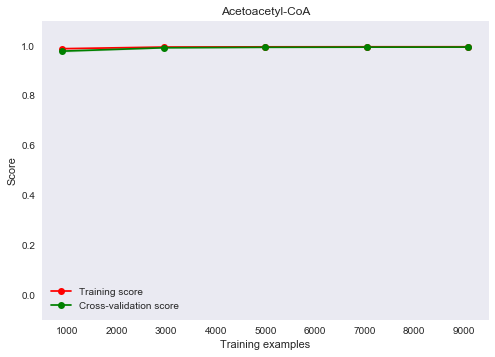

Acetyl-CoA


Optimization Progress:  28%|██▊       | 17/60 [00:23<01:50,  2.58s/pipeline]

Generation 1 - Current best internal CV score: 5.044464109132538e-08


Optimization Progress:  43%|████▎     | 26/60 [00:33<00:45,  1.34s/pipeline]

Generation 2 - Current best internal CV score: 4.992630191534286e-08


Optimization Progress:  60%|██████    | 36/60 [00:49<00:45,  1.91s/pipeline]

Generation 3 - Current best internal CV score: 4.992630191534286e-08


Optimization Progress:  75%|███████▌  | 45/60 [01:12<00:27,  1.83s/pipeline]

Generation 4 - Current best internal CV score: 4.992630191534286e-08


Generation 5 - Current best internal CV score: 2.3192924125357816e-08

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=DEFAULT, ExtraTreesRegressor__min_samples_leaf=3, ExtraTreesRegressor__min_samples_split=2, ExtraTreesRegressor__n_estimators=100)
Acetyl-CoA


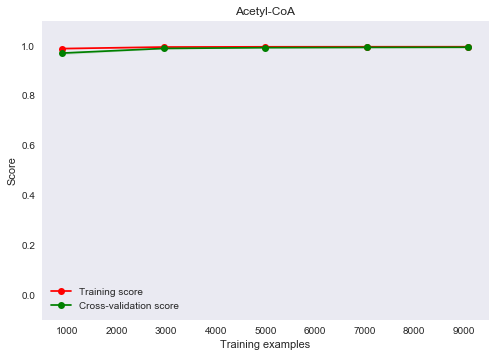

DMAPP


Optimization Progress:  33%|███▎      | 20/60 [00:11<00:21,  1.90pipeline/s]

Generation 1 - Current best internal CV score: 9.719627170311164e-10


Optimization Progress:  50%|█████     | 30/60 [00:17<00:22,  1.35pipeline/s]

Generation 2 - Current best internal CV score: 3.364031978520577e-10


Optimization Progress:  68%|██████▊   | 41/60 [00:19<00:06,  2.92pipeline/s]

Generation 3 - Current best internal CV score: 3.364031978520577e-10


Optimization Progress:  83%|████████▎ | 50/60 [00:21<00:02,  3.74pipeline/s]

Generation 4 - Current best internal CV score: 1.1245644650543397e-10


Generation 5 - Current best internal CV score: 1.1245644650543397e-10

Best pipeline: KNeighborsRegressor(MaxAbsScaler(input_matrix), KNeighborsRegressor__n_neighbors=37, KNeighborsRegressor__p=1, KNeighborsRegressor__weights=distance)
DMAPP


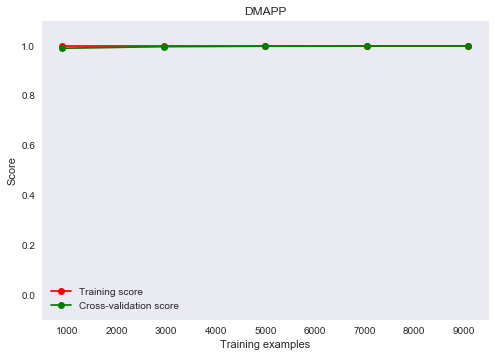

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]

GPP


Optimization Progress:  33%|███▎      | 20/60 [00:25<01:37,  2.44s/pipeline]

Generation 1 - Current best internal CV score: 2.5549047821746116e-09


Optimization Progress:  50%|█████     | 30/60 [00:35<01:18,  2.63s/pipeline]

Generation 2 - Current best internal CV score: 1.1960154742860155e-09


Optimization Progress:  67%|██████▋   | 40/60 [01:11<00:58,  2.93s/pipeline]

Generation 3 - Current best internal CV score: 1.1960154742860155e-09


Optimization Progress:  83%|████████▎ | 50/60 [01:31<00:22,  2.29s/pipeline]

Generation 4 - Current best internal CV score: 1.1960154742860155e-09


Generation 5 - Current best internal CV score: 1.1960154742860155e-09

Best pipeline: RidgeCV(StandardScaler(GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.8, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=quantile, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.6, GradientBoostingRegressor__min_samples_leaf=11, GradientBoostingRegressor__min_samples_split=9, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.55)))
GPP


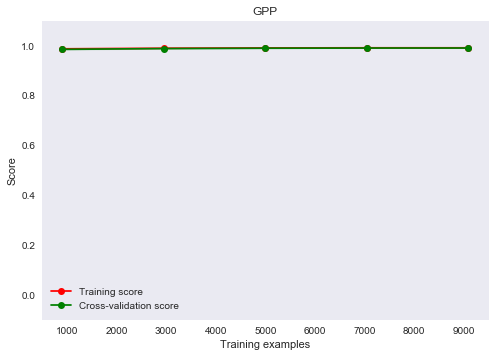

HMG-CoA


Optimization Progress:  32%|███▏      | 19/60 [00:59<02:55,  4.27s/pipeline]

Generation 1 - Current best internal CV score: 3.3643009805650476e-08


Optimization Progress:  48%|████▊     | 29/60 [01:45<02:41,  5.20s/pipeline]

Generation 2 - Current best internal CV score: 1.704868341192417e-08


Optimization Progress:  63%|██████▎   | 38/60 [02:18<01:56,  5.28s/pipeline]

Generation 3 - Current best internal CV score: 1.704868341192417e-08


Optimization Progress:  80%|████████  | 48/60 [02:59<00:58,  4.85s/pipeline]

Generation 4 - Current best internal CV score: 1.704868341192417e-08


Generation 5 - Current best internal CV score: 1.4366877546259137e-08

Best pipeline: ExtraTreesRegressor(RidgeCV(input_matrix), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.6, ExtraTreesRegressor__min_samples_leaf=DEFAULT, ExtraTreesRegressor__min_samples_split=9, ExtraTreesRegressor__n_estimators=100)
HMG-CoA


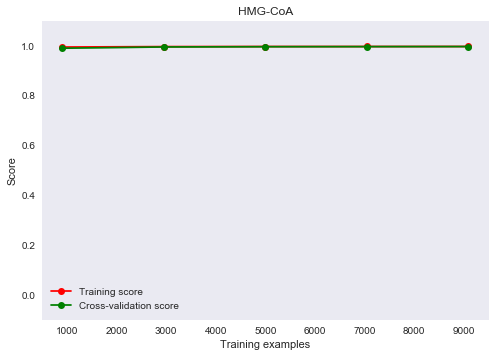

IPP


Optimization Progress:  32%|███▏      | 19/60 [00:26<01:34,  2.30s/pipeline]

Generation 1 - Current best internal CV score: 7.92069898438318e-08


Optimization Progress:  47%|████▋     | 28/60 [01:31<05:12,  9.77s/pipeline]

Generation 2 - Current best internal CV score: 4.730003712316646e-08


Optimization Progress:  63%|██████▎   | 38/60 [02:27<03:17,  8.99s/pipeline]

Generation 3 - Current best internal CV score: 4.6917337109020665e-08


Optimization Progress:  80%|████████  | 48/60 [04:14<02:25, 12.16s/pipeline]

Generation 4 - Current best internal CV score: 3.699686620317663e-08


Generation 5 - Current best internal CV score: 3.699686620317663e-08

Best pipeline: RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.7, RandomForestRegressor__min_samples_leaf=3, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimators=100)
IPP


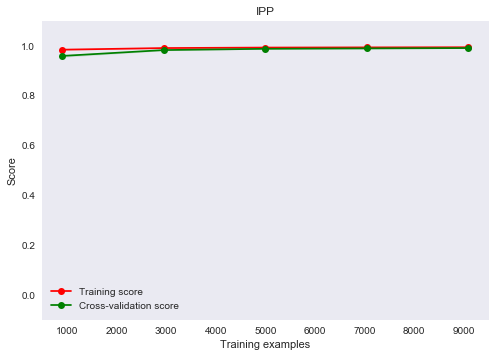

Limonene


Optimization Progress:  33%|███▎      | 20/60 [00:26<01:06,  1.66s/pipeline]

Generation 1 - Current best internal CV score: 1.591315248001959e-09


Optimization Progress:  47%|████▋     | 28/60 [00:32<00:32,  1.00s/pipeline]

Generation 2 - Current best internal CV score: 1.591315248001959e-09


Optimization Progress:  57%|█████▋    | 34/60 [00:39<00:30,  1.17s/pipeline]

Generation 3 - Current best internal CV score: 1.4158170280877176e-09


Optimization Progress:  70%|███████   | 42/60 [00:48<00:20,  1.13s/pipeline]

Generation 4 - Current best internal CV score: 8.168163274816968e-10


Generation 5 - Current best internal CV score: 8.168163274816968e-10

Best pipeline: GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.9, GradientBoostingRegressor__learning_rate=0.5, GradientBoostingRegressor__loss=quantile, GradientBoostingRegressor__max_depth=9, GradientBoostingRegressor__max_features=DEFAULT, GradientBoostingRegressor__min_samples_leaf=12, GradientBoostingRegressor__min_samples_split=DEFAULT, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.75)
Limonene


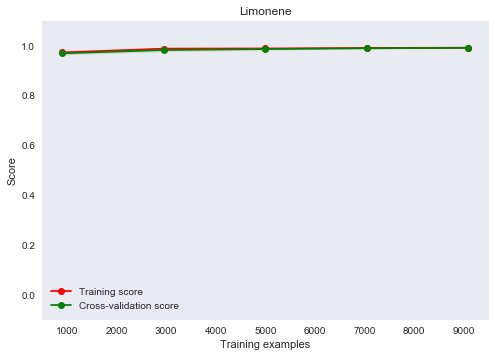

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]

Mev


Optimization Progress:  33%|███▎      | 20/60 [00:18<00:53,  1.34s/pipeline]

Generation 1 - Current best internal CV score: 4.532597651879936e-07


Optimization Progress:  48%|████▊     | 29/60 [00:49<01:46,  3.45s/pipeline]

Generation 2 - Current best internal CV score: 1.1918460891995888e-07


Optimization Progress:  65%|██████▌   | 39/60 [01:14<01:03,  3.02s/pipeline]

Generation 3 - Current best internal CV score: 1.0649914767395616e-07


Optimization Progress:  82%|████████▏ | 49/60 [01:55<00:49,  4.54s/pipeline]

Generation 4 - Current best internal CV score: 8.189673486518428e-08


Generation 5 - Current best internal CV score: 8.189673486518428e-08

Best pipeline: GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.75, GradientBoostingRegressor__learning_rate=0.5, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.65, GradientBoostingRegressor__min_samples_leaf=14, GradientBoostingRegressor__min_samples_split=19, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.85)
Mev


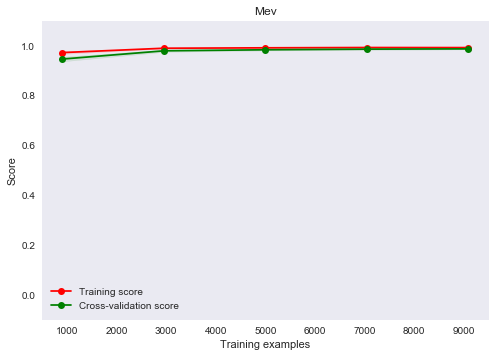

MevP


Optimization Progress:  32%|███▏      | 19/60 [00:58<03:02,  4.45s/pipeline]

Generation 1 - Current best internal CV score: 2.8352270900933697e-07


Optimization Progress:  48%|████▊     | 29/60 [01:53<03:39,  7.09s/pipeline]

Generation 2 - Current best internal CV score: 8.326459899661449e-08


Optimization Progress:  63%|██████▎   | 38/60 [02:22<01:47,  4.88s/pipeline]

Generation 3 - Current best internal CV score: 5.999080462709195e-08


Optimization Progress:  78%|███████▊  | 47/60 [03:00<01:04,  4.94s/pipeline]

Generation 4 - Current best internal CV score: 5.999080462709195e-08


Generation 5 - Current best internal CV score: 5.415352463553445e-08

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=True, ExtraTreesRegressor__max_features=DEFAULT, ExtraTreesRegressor__min_samples_leaf=3, ExtraTreesRegressor__min_samples_split=DEFAULT, ExtraTreesRegressor__n_estimators=100)
MevP


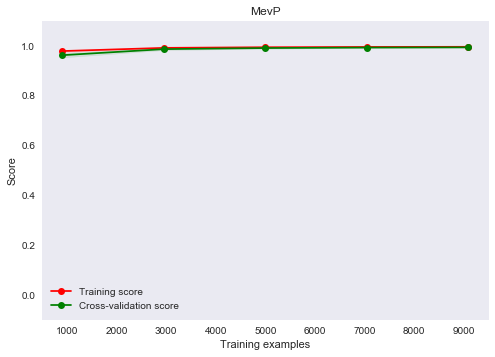

MevPP


Optimization Progress:  33%|███▎      | 20/60 [00:36<01:14,  1.85s/pipeline]

Generation 1 - Current best internal CV score: 7.050556481968574e-08


Optimization Progress:  50%|█████     | 30/60 [00:52<01:03,  2.12s/pipeline]

Generation 2 - Current best internal CV score: 4.575836581264876e-08


Optimization Progress:  67%|██████▋   | 40/60 [00:57<00:17,  1.12pipeline/s]

Generation 3 - Current best internal CV score: 4.575836581264876e-08


Optimization Progress:  83%|████████▎ | 50/60 [01:19<00:17,  1.75s/pipeline]

Generation 4 - Current best internal CV score: 2.985586497060655e-08


Generation 5 - Current best internal CV score: 2.985586497060655e-08

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.45, ExtraTreesRegressor__min_samples_leaf=2, ExtraTreesRegressor__min_samples_split=DEFAULT, ExtraTreesRegressor__n_estimators=100)
MevPP


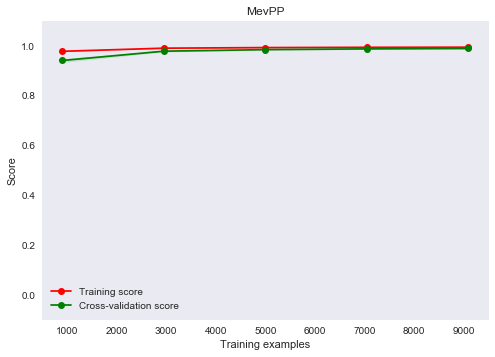

Average Training Score: 0.995019749917 n: 10


In [9]:
#1. Calculate Learning Curves for Derivatives

#Pick number of strains so that the total number is equal to max tested strains...
if data_type == 'simulated':
    strains = tsdf.index.get_level_values(0).unique()
    tsdf_max_strains = tsdf.loc[slice(strains[0],strains[max(strain_numbers)]),slice(None)]
else:
    tsdf_max_strains = tsdf

average_training_score = 0
n = 0
for target_index in tsdf_max_strains.columns:
    if target_index[0] == 'feature':
        continue
    n += 1
    target = target_index[1]
    print(target)


    feature_indecies = [('feature', feature) for feature in specific_features[target]]
    X = tsdf_max_strains[feature_indecies].values.tolist()
    y = tsdf_max_strains[target_index].values.tolist()

    #if fit_log_targets:
    #    y = [math.log(val) for val in y]
    
    #print(X)
    #print(y)
    if model_str == 'tpot':
        modelDict[target] = clone(mlmodel).fit(np.array(X),np.array(y)).fitted_pipeline_
        try:
            crossValPlot = plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
        except:
            pass
    else:
        modelDict[target] = clone(mlmodel)
        crossValPlot = plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
    
    ax = plt.gca()
    ax.set_ylim([-0.1, 1.1])
    strip_target = ''.join([char for char in target if char != '/'])
    print(strip_target)
    crossValPlot.savefig('figures/' + strip_target + 'CrossValPlot.pdf',transparent=False)
    plt.show()
    
    #Save out Cross Validation Plot
    
    modelDict[target] = modelDict[target].fit(X,y)
    average_training_score +=  modelDict[target].score(X,y)
    #print(modelDict[target_name].predict([reduced_features[2]]))
    
average_training_score /= n
print('Average Training Score:',average_training_score,'n:',n)

Total Time Series in Data Set:  1200


feature                                               \
                 Acetoacetyl-CoA Acetyl-CoA          AtoB     DMAPP       GPP   
Strain Time (h)                                                                 
10     0.000000         0.200124   0.200133  7.162759e+04  0.199999  0.199998   
       0.696970         0.198776   0.208485  6.044323e+05  0.200054  0.200162   
       1.393939         0.197010   0.216387  1.018899e+06  0.200114  0.200333   
       2.090909         0.194825   0.223841  1.315029e+06  0.200179  0.200510   
       2.787879         0.192108   0.230724  1.434891e+06  0.200250  0.200696   
       3.484848         0.189100   0.237293  1.503816e+06  0.200323  0.200885   
       4.181818         0.185884   0.243640  1.557903e+06  0.200400  0.201080   
       4.878788         0.182515   0.249822  1.602496e+06  0.200479  0.201280   
       5.575758         0.179005   0.255852  1.637340e+06  0.200561  0.201485   
       6.272727         0.175361   0.261737  1.665005e+06  0.200646  0.201696   
       6.969697         0.171604   0.267501  1.688044e+06  0.200734  0.201912   
       7.666667         0.167752   0.273162  1.707586e+06  0.200824  0.202134   
       8.363636         0.163803   0.278718  1.723980e+06  0.200917  0.202362   
       9.060606         0.159767   0.284179  1.738034e+06  0.201013  0.202595   
       9.757576         0.155661   0.289563  1.750462e+06  0.201111  0.202832   
       10.454545        0.151481   0.294867  1.761289e+06  0.201211  0.203075   
       11.151515        0.147233   0.300097  1.770808e+06  0.201314  0.203322   
       11.848485        0.142928   0.305264  1.779374e+06  0.201418  0.203575   
       12.545455        0.138570   0.310372  1.787057e+06  0.201525  0.203831   
       13.242424        0.134160   0.315421  1.793943e+06  0.201635  0.204092   
       13.939394        0.129705   0.320421  1.800198e+06  0.201746  0.204358   
       14.636364        0.125212   0.325378  1.805923e+06  0.201859  0.204627   
       15.333333        0.120681   0.330292  1.811131e+06  0.201975  0.204900   
       16.030303        0.116120   0.335170  1.815900e+06  0.202092  0.205177   
       16.727273        0.111535   0.340019  1.820323e+06  0.202211  0.205458   
       17.424242        0.106928   0.344842  1.824396e+06  0.202331  0.205742   
       18.121212        0.102306   0.349645  1.828157e+06  0.202454  0.206029   
       18.818182        0.097676   0.354435  1.831674e+06  0.202578  0.206320   
       19.515152        0.093042   0.359217  1.834951e+06  0.202703  0.206614   
       20.212121        0.088411   0.363997  1.838001e+06  0.202830  0.206911   
...                          ...        ...           ...       ...       ...   
9999   48.787879        0.147831   0.737931  5.519967e+06  0.186995  0.216413   
       49.484848        0.146857   0.744873  5.520454e+06  0.186794  0.216682   
       50.181818        0.145882   0.751802  5.520927e+06  0.186592  0.216952   
       50.878788        0.144905   0.758719  5.521387e+06  0.186391  0.217221   
       51.575758        0.143926   0.765625  5.521835e+06  0.186189  0.217491   
       52.272727        0.142946   0.772518  5.522271e+06  0.185988  0.217760   
       52.969697        0.141965   0.779401  5.522695e+06  0.185788  0.218029   
       53.666667        0.140984   0.786273  5.523109e+06  0.185587  0.218297   
       54.363636        0.140001   0.793133  5.523512e+06  0.185387  0.218566   
       55.060606        0.139018   0.799983  5.523904e+06  0.185187  0.218834   
       55.757576        0.138034   0.806823  5.524287e+06  0.184987  0.219102   
       56.454545        0.137050   0.813653  5.524661e+06  0.184787  0.219370   
       57.151515        0.136065   0.820473  5.525025e+06  0.184588  0.219637   
       57.848485        0.135081   0.827283  5.525381e+06  0.184388  0.219905   
       58.545455        0.134097   0.834085  5.525729e+06  0.184190  0.220172   
       59.242424        0.133113   0.840876  5.526068e+0

Acetoacetyl-CoA Mean Error: -3.18503032409e-05 Error Standard Deviation: 0.000188938850944


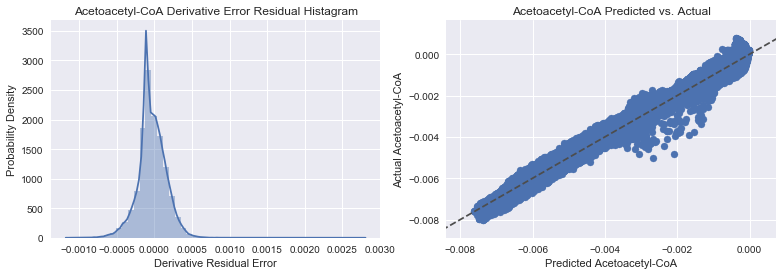

Acetyl-CoA Mean Error: -7.6196433525e-06 Error Standard Deviation: 0.000212553016274


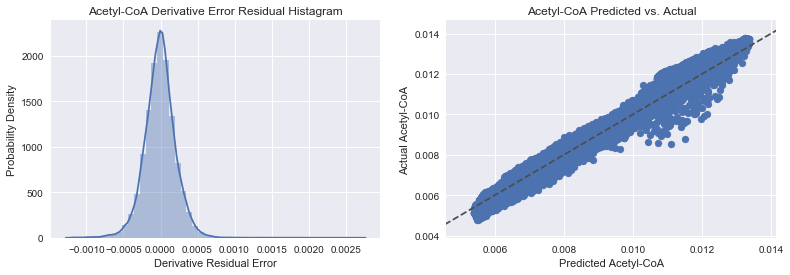

DMAPP Mean Error: -2.61999356403e-06 Error Standard Deviation: 5.26759020189e-05


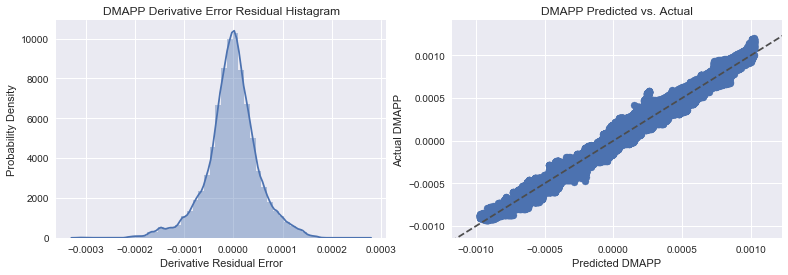

GPP Mean Error: -2.1395888184e-06 Error Standard Deviation: 5.32566024911e-05


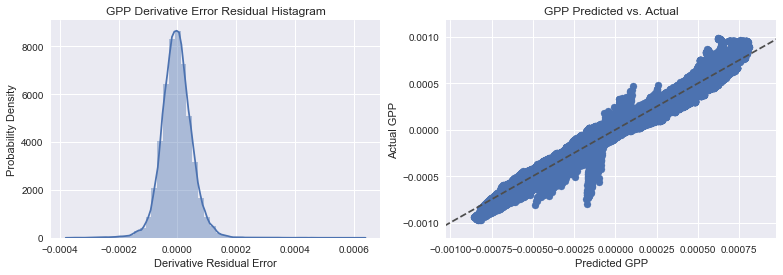

HMG-CoA Mean Error: -1.57925210411e-05 Error Standard Deviation: 0.0001771472463


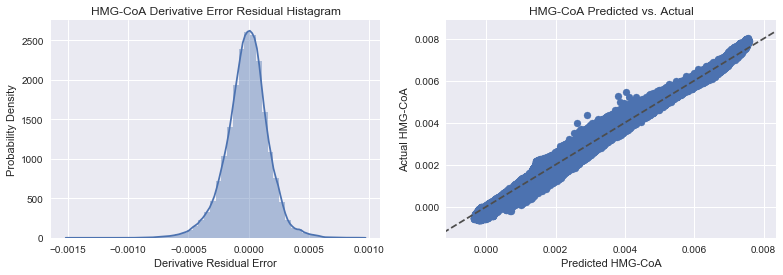

IPP Mean Error: 0.000100759612992 Error Standard Deviation: 0.000421207548983


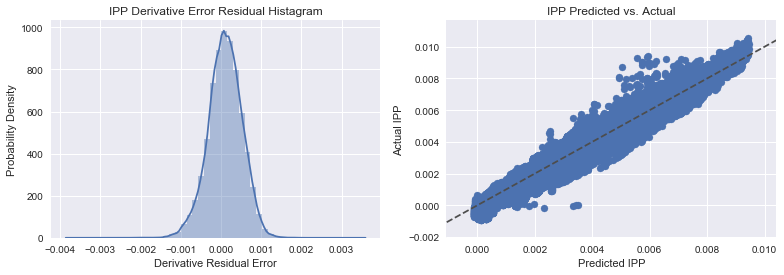

Limonene Mean Error: 9.06862605138e-06 Error Standard Deviation: 3.19026087927e-05


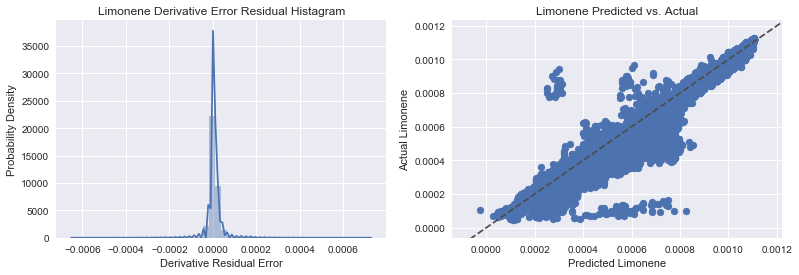

Mev Mean Error: -3.22595547784e-05 Error Standard Deviation: 0.000377673823673


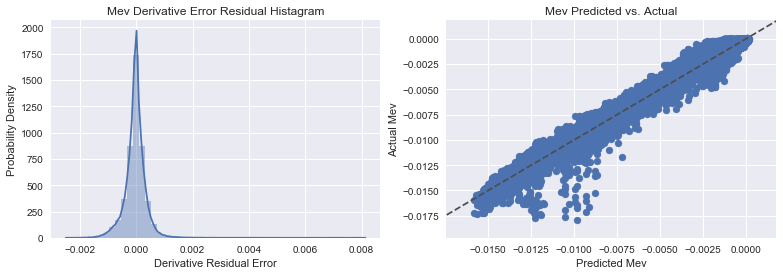

MevP Mean Error: 1.45777908255e-05 Error Standard Deviation: 0.000295847353909


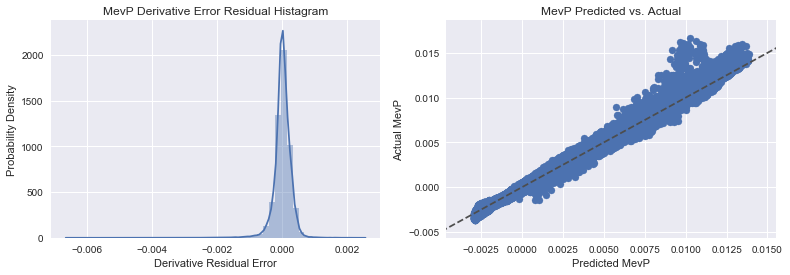

MevPP Mean Error: -8.84337226831e-05 Error Standard Deviation: 0.000342768565043


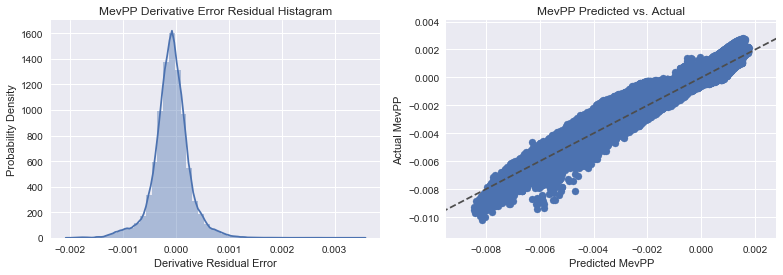

Total Derivative Mean Error: 0.000725400230648 Error Standard Deviation: 0.000372010997217


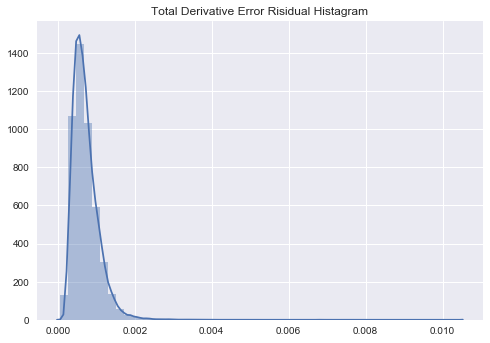

In [10]:
#2. Calculate Error Distribution and Plot + Report Moments
ts_test_df = generateTSDataSet(test_df,features,targets)
display(ts_test_df)
errors = []
for target in modelDict:
    times,y_test = remove_NaN(ts_test_df.reset_index()['Time (h)'].values,ts_test_df[('target',target)].values)
    
    feature_list = [('feature',feature) for feature in specific_features[target]]
    target_df = ts_test_df[feature_list]
    target_df = target_df[ts_test_df.index.get_level_values('Time (h)').isin(times)]
    
    #Check to make sure there are no NaNs in each feature
    for feature in target_df.columns:
        if any([math.isnan(val) for val in target_df[feature].values]):
            X,y = remove_NaN(target_df.reset_index()['Time'].values,target_df[feature].values)
            fnc = interp1d(X,y)
        index = 0
        for time,val in zip(times,target_df[feature].values):
            if math.isnan(val):
                #print(feature,time,fnc(time))
                target_df[feature].iloc[index] = fnc(time)
            index += 1
    #display(target_df)
    
    y_prediction = modelDict[target].predict(target_df.values)
    
    #print(y_prediction)
    #print(y_test)
    log_error = [math.log(max(y_p,0.0001)) - math.log(max(y_t,0.0001)) for y_p,y_t in zip(y_prediction,y_test)]
    error = [y_p - y_t for y_p,y_t in zip(y_prediction,y_test)]
    errors.append(error)
    
    mu = np.mean(error)
    sigma = np.std(error)
    print(target,'Mean Error:',mu,'Error Standard Deviation:',sigma)
    
    plt.figure(figsize=(13,4))
    plt.subplot(121)
    sns.distplot(error)
    plt.title(target + ' Derivative '+ 'Error Residual Histagram')
    plt.xlabel('Derivative Residual Error')
    plt.ylabel('Probability Density')
    
    plt.subplot(122)
    plot_model_fit(target,y_prediction,y_test)
    
    strip_target = ''.join([char for char in target if char != '/'])
    plt.savefig('figures/' + strip_target + 'ErrorResiduals.pdf')
    plt.show()
    
    #modelDict[target].predict()

#Compute Net Error Magnitude
error_magnitude = [0]*len(errors[0])
for error in errors:
    error_magnitude = [em + e**2 for em,e in zip(error_magnitude,error)]
error_magnitude = [math.sqrt(e) for e in error_magnitude]
mu = np.mean(error_magnitude)
sigma = np.std(error_magnitude)
print('Total Derivative','Mean Error:',mu,'Error Standard Deviation:',sigma)
    
sns.distplot(error_magnitude)
plt.title('Total Derivative Error Risidual Histagram')
plt.show()

In [11]:
# If Experimental Limonene Results show that the Hand created 
# Kinetic Model Does not fit as well as the machine learning model

def proteomicsData(t,k):
    e = []
    for i in range(int(len(k)/3)):
        #Sorting the gains to ensure proteins only increase
        gains = sorted(k[3*i:3*(i+1)],reverse=True)
        e.append(leaky_hill_fcn(t,*gains)) 
    return e


def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9,
                  s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,
                  k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35,
                  k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65,
                  k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3):
    r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
    r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45)
    r5 = k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5)
    r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
    r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
    r10 = k91*e9*s9 / (k92 + s9)
    return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
    
def solve_kinetic_ode(f,y0,times,k_fit):
    sol = 1
    return sol

measured_substrates = ['Acetyl-CoA (uM)', 'HMG-CoA (uM)', 'Intracellular Mevalonate (uM)', 'Mev-P (uM)', 'IPP/DMAPP (uM)', 'Limonene g/L']
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'Limonene Synthase']
x_features = [('feature',val) for val in measured_enzymes+measured_substrates]
y_targets = [('target',val) for val in measured_substrates]

#print(x_features)
#print(y_targets)

if data_type == 'experimental' and  pathway == 'limonene':
    [('feature', feature) for feature in specific_features[target]]
    X = tsdf_max_strains[x_features].values.tolist()
    y = tsdf_max_strains[y_targets].values.tolist()
    
    #Solve for Kinetic Coefficients from Training Set
    def cost_fcn_gen(X,y):
        def cost_fcn(free_params):
            cost = 0
            for x_val,y_vals in zip(X,y):
                params = []
                params.extend(x_val[0:6])       # AtoB to PMD Values
                params.extend(free_params[0:2]) # Keep Constant GPPS and IDI levels as free parameters
                params.extend(x_val[6:8])       # LS and Acetyl-CoA
                params.append(free_params[2])   # AcetoAcetyl-CoA as a free Param
                params.extend(x_val[8:11])      # HMG-CoA & Mev & MevP measured
                params.append(free_params[3])   #MevPP 
                params.extend([x_val[11],x_val[11]]) #DMAPP & IDI Measured
                params.extend([free_params[4],x_val[12]]) #GPP as a Free Parameter #Measured Limonene Synthase
                params.extend(free_params[5:])  # Remaining Kinetic Free Parameters
                
                mp = kinetic_model(*params)
                prediction = [mp[0],mp[2],mp[3],mp[4],mp[6]+mp[7],mp[9]]
                cost += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
            return cost
        return cost_fcn

    cost_fcn = cost_fcn_gen(X,y)
    
    #Call to check its working (num free params = 39)
    print(cost_fcn([1,]*39))
    
    #Solve For Optimal Parameters
    bounds = [(1*10**-12,10**9)]*39
    sol = differential_evolution(cost_fcn,bounds,disp=True,maxiter=10000)
    best_params = sol.x
    print(best_params)

In [12]:
import statistics

def plot_species_curves(modelDict, title, df, targets, specific_features, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 3),training_sets=5):
    """
    Generate a simple plot of the test and training learning curve. Returns Metrics for each predicted curve

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    #Set Random Seed For training
    #seed = 103
    #random.seed(seed)
    
    #Create figure / plots
    fig = plt.figure(figsize=(12,16))
    #fig.set_title(title)
    #if ylim is not None:
    #    plt.ylim(*ylim)
    
    #Create subplots for each target
    ax = {}
    for i,target in enumerate(targets):
        ax[target] = plt.subplot(int(len(targets)/2), 2, i+1)
    
    #Get Randomized List of all Strains
    strains = df.index.get_level_values(0).unique()
    strains = list(strains.values)
    #print(strains)
    strains = random.sample(strains, len(strains))
    
    #Pick test strain
    test_df = df.loc[(slice(strains[0],strains[0]),slice(None)),:]
    strains = strains[1:]
    
    #Create Interpolation functions for each feature in the test strain
    interpFun = {}
    #display(test_df.reset_index())
    for feature in df.columns:
        X,y = remove_NaN(test_df.reset_index()['Time (h)'].tolist(),test_df[feature].tolist())
        if isinstance(feature,tuple):
            if feature[0] == 'feature':
                feature = feature[1]
            else:
                continue

        interpFun[feature] = interp1d(X,y)  

    train_sizes = [int(len(strains)*size/training_sets)-1 for size in train_sizes]
    for i,size in enumerate(train_sizes):
        if size < 2:
            train_sizes[i] = 2
            
    #Create Fits for each training set
    fits = {}
    for training_set in range(training_sets):        
        fits[training_set] = {}

        #Generate training strain data for this training set
        training_strains = strains[0:(train_sizes[-1] + 1)]
        #print(training_strains)
        strains = strains[train_sizes[-1]:]
        endSamples = train_sizes
        #print('Strains:',strains)
        #print('End Samples',endSamples)
        sample_sets = [df.loc[(training_strains[0:endSample],slice(None)),:] for endSample in endSamples]

        #For each set size in the training set fit the model and store it
        for j,sample_set in enumerate(sample_sets):
            
            #print('Sample Set:',sample_set.index.get_level_values(0).unique().values)
            
            # Train Model
            print('Training Models for Training Set',training_set,'In Sample set',j)
            for target in targets:
                feature_indecies = [('feature', feature) for feature in specific_features[target]]
                X = sample_set[feature_indecies].values.tolist()

                #print(feature_indecies)
                #display(sample_set[feature_indecies])
                target_index = ('target',target)
                y = sample_set[target_index].values.tolist()
                modelDict[target].fit(X,y)

            print('Integrating ODEs!')
            # Integrate Given Model Test Case
            g = mlode(modelDict, test_df, targets, specific_features)
            times = test_df.reset_index()['Time (h)'].tolist()

            #Set Y0 initial condition
            appended_targets = [('feature',target) for target in targets]
            #display(test_df)
            #display(test_df[appended_targets].iloc[0])
            y0 = test_df[appended_targets].iloc[0].tolist()

            #print('times:',times)
            fit  = odeintz(g,y0,times)
            fitT = list(map(list, zip(*fit)))
            fits[training_set][train_sizes[j]] = fitT

    
    #Perform Statistics on Fits and generate plots
    colors = ['b','g','k','y','m']
    predictions = {}
    lines =[]
    labels = []
    for k,target in enumerate(targets):
        actual_data = [interpFun[target](t) for t in times]
        predictions[target] = {'actual':actual_data}
        predictions['Time'] = times
        if k == 0:
            lines.append(ax[target].plot(times,actual_data,'--', color='r')[0])
            labels.append('Actual Dynamics')
        else:
            ax[target].plot(times,actual_data,'--', color='r')
        ax[target].set_title(target)
        
        for j in range(len(sample_sets)):
            upper = []
            lower = []
            aves = []
            
            predictions[target][train_sizes[j]] = []
            for training_set in range(training_sets):
                predictions[target][train_sizes[j]].append(fits[training_set][train_sizes[j]][k])
            
            for i,time in enumerate(times):
                
                values = []
                for training_set in range(training_sets):
                    #print(training_set,train_sizes[j],i)
                    values.append(fits[training_set][train_sizes[j]][k][i])

                #Compute Statistics of Values
                #print(values)
                ave = statistics.mean(values)
                std = statistics.stdev(values)
                aves += [ave,]
                upper += [ave + std,]
                lower += [ave - std,]
                
                #print(upper)
                #print(times)
                
            #Compute upper and lower bounds for shading
            ax[target].fill_between(times, lower,upper, alpha=0.1, color=colors[j])
            if k == 0:
                lines.append(ax[target].plot(times,aves,colors[j])[0])
                labels.append(str(train_sizes[j]) + ' Strain Prediction')
            else:
                ax[target].plot(times,aves,colors[j])
            print(colors[j],train_sizes[j])
        plt.figlegend( lines, labels, loc = 'lower center', ncol=5, labelspacing=0. )       

    return predictions

Training Models for Training Set 0 In Sample set 0
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 0 In Sample set 1
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 0 In Sample set 2
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 1 In Sample set 0
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 1 In Sample set 1
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 1 In Sample set 2
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP

Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 16 In Sample set 0
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 16 In Sample set 1
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 16 In Sample set 2
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 17 In Sample set 0
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 17 In Sample set 1
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training

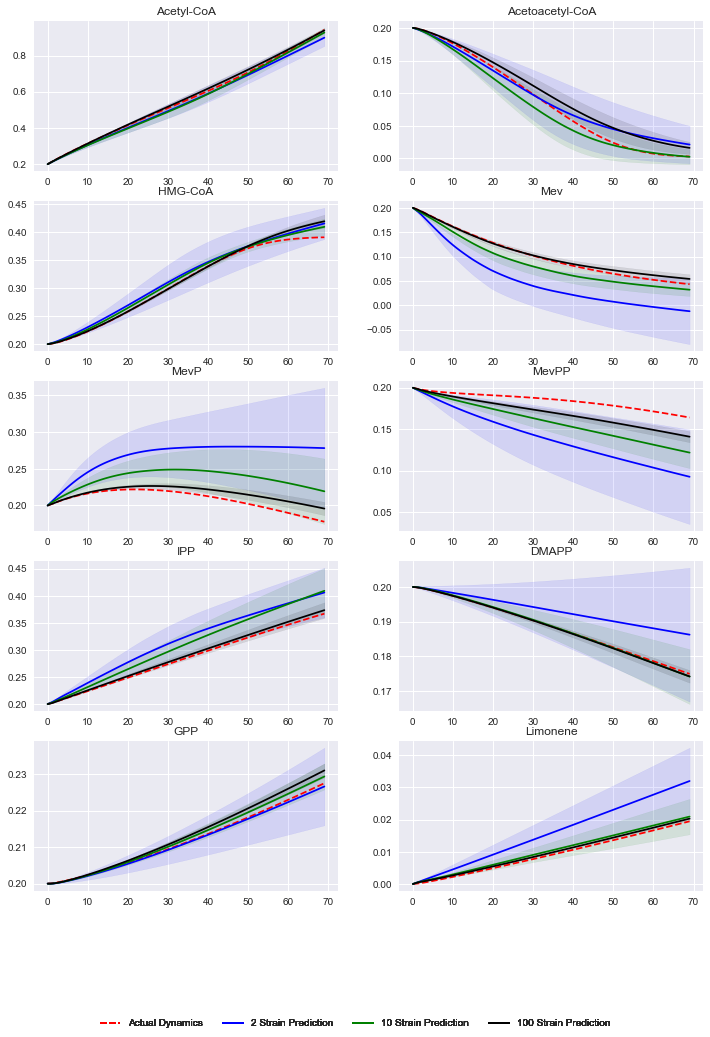

In [13]:
#3. Plot Comparison between Actual and Predicted Results
if data_type == 'simulated':
    real_vs_predicted = plot_species_curves(modelDict, 'title', tsdf, targets, specific_features,train_sizes=train_sizes,training_sets=training_sets)
    plt.savefig('figures/MainFigure.pdf')
    
    
elif data_type == 'experimental':
    #Fit each test strain by solving the differential equation

    #Select Random Time Series
    strains = test_df.index.get_level_values(0).unique()
    random_strain = random.sample(tuple(strains), 1)
    random_strain = list(random_strain)[0]
    random_df = test_df.loc[(slice(random_strain,random_strain),slice(None)),:]

    #Set Y0 initial condition
    y0 = random_df[targets].iloc[0].tolist()
    print('y0',y0)
    
    #Create Differential Equation to Solve
    if featureReduction:
        target_features = [header[1:]]*len(targets[0])
        g = mlode(modelDict, random_df, targets, specific_features)
    else:
        g = mlode(modelDict, random_df, targets, specific_features,time_index='Time')

    #Solve Differential Equation numerically using a runge-kutta 4,5 implementation
    times = random_df.reset_index()['Time'].tolist()
    fit = odeintz(g,y0,times)
    fitT = list(map(list, zip(*fit)))
    
    
    #Create Interpolation functions for each feature
    interpFun = {}
    for feature in random_df.columns:
        X,y = remove_NaN(random_df.reset_index()['Time'].tolist(),random_df[feature].tolist())
        interpFun[feature] = interp1d(X,y)

        
    if pathway == 'limonene':
        #print(random_df.columns)
        proteins = ['AtoB', 'HMGR', 'HMGS', 'MK', 'PMD', 'PMK','Limonene Synthase']
        protein_fcns= []
        for feature in random_df.columns:
            X,y = remove_NaN(random_df.reset_index()['Time'].tolist(),random_df[feature].tolist())
            protein_fcns.append(interp1d(X,y))
        
        #Generate Fit Kinetic Model ODE
        def kinetic_ode(x,t,proteomic_fcns):
            
            #proteomics 
            proteomic_data = [proteomic_fcn(t) for proteomic_fcn in proteomic_fcns]

            params = []
            params.extend(proteomic_data[0:6]) # AtoB to PMD Values
            params.extend(best_params[0:2])     # Keep Constant GPPS and IDI levels as free parameters
            params.append(proteomic_data[6])   # 
            params.append(x[0])                #Acetyl-CoA
            params.append(best_params[2])       # AcetoAcetyl-CoA as a free Param
            params.extend(x[1:4])               # HMG-CoA & Mev & MevP measured
            params.append(best_params[3])       # MevPP 
            params.extend([x[4],x[4]])          # DMAPP & IDI Measured
            params.extend([best_params[4],x[5]]) # GPP as a Free Parameter #Measured Limonene Synthase
            params.extend(best_params[5:])      # Remaining Kinetic Free Parameters
            
            
            dxdt = kinetic_model(*params)
            dxdt_combined = [dxdt[0],dxdt[2],dxdt[3],dxdt[4],dxdt[6]+dxdt[7],dxdt[9]]
            return dxdt_combined
        
        for protein in proteins:
            protein_fcns.append(interpFun[protein])
        
        #Solve Kinetic ODE at initial Conditions
        kinetic_ode_p = lambda x,t : kinetic_ode(x,t,protein_fcns)
        kinetic_fit = odeintz(kinetic_ode_p,y0,times)
        kinetic_fit = list(map(list, zip(*kinetic_fit)))
        
    real_vs_predicted = {}
    plt.figure(figsize=(12,8))
    for i,target in enumerate(targets):
        plt.subplot(2,3,i+1)
        if data_type == 'experimental':
            #Plot both High and Low Strain values
            for strain in training_strains:
                strainInterpFun = {}
                strain_df = df.loc[(strain,slice(None))]
                X,y = remove_NaN(strain_df.reset_index()['Time'].tolist(),strain_df[target].tolist())
                strainInterpFun[target] = interp1d(X,y)
                actual_data = [strainInterpFun[target](t) for t in times]
                train_line, = plt.plot(times,actual_data,'r--')
            
            #Plot Kinetic Model Fit
            if pathway =='limonene':
                kinetic_pred = [max(kinetic_fit[i][j],0) for j,t in enumerate(times)]
                kinetic_line, = plt.plot(times,kinetic_pred,color='k')

        actual_data = [interpFun[target](t) for t in times]
        pos_pred = [max(fitT[i][j],0) for j,t in enumerate(times)]
        prediction_line, = plt.plot(times,pos_pred)
        #print(actual_data)
        test_line, = plt.plot(times,actual_data,'g--')
        plt.ylabel(target)
        plt.xlabel('Time [h]')
        plt.xlim([0,72])
        
        if i == 5 and pathway == 'limonene':
            plt.ylim([0,0.6])
        
        #Create variable for processing error residuals
        if pathway == 'limonene':
            real_vs_predicted[target] = [times,actual_data,pos_pred,kinetic_pred]
        else:
            real_vs_predicted[target] = [times,actual_data,pos_pred]
    #Add Legend
    if set_num==2:
        product = 'Isopentenol'
    elif set_num==3:
        product = 'Limonene'
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.subplots_adjust(bottom=0.12)
    plt.suptitle('Prediction of ' + product + ' Strain Dynamics', fontsize=18)
    if pathway == 'limonene':
        plt.figlegend( (train_line,test_line,prediction_line,kinetic_line), ('Training Set Data','Test Data','Machine Learning Model Prediction','Kinetic Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. )  
    else:
        plt.figlegend( (train_line,test_line,prediction_line), ('Training Set Data','Test Data','Machine Learning Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. ) 
    plt.savefig('data/' + product + '_prediction.eps', format='eps', dpi=600)
    plt.show()

In [14]:
#4. Error Residuals of Time Series Data + Key Moments Report

#Not Quite Right... Need to Integrate over the 
if data_type == 'experimental':
    #print(real_vs_predicted)

    rmse_percent = []
    rmse_average = []
    rmse_percent_k = []
    rmse_average_k = []
    for metabolite in real_vs_predicted:
        if pathway == 'limonene':
            times,real,predicted,kinetic = real_vs_predicted[metabolite]
        else:
            times,real,predicted = real_vs_predicted[metabolite]
        real_fcn = interp1d(times,real)
        pred_fcn = interp1d(times,predicted)

        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
        rmse = math.sqrt(quad(integrand,min(times),max(times))[0])
        rmse_average.append(rmse)
        percent_integrand = lambda t: abs(real_fcn(t) - pred_fcn(t))/(real_fcn(t)*max(times))
        #print(metabolite,[percent_integrand(t) for t in times],[real_fcn(t) for t in times],[pred_fcn(t) for t in times])
        
        rmsep = math.sqrt(quad(percent_integrand,min(times),max(times))[0])
        rmse_percent.append(rmsep)
        print('ML Fit:',metabolite,rmse,'RMSE percent:',rmsep*100)
        
        if pathway == 'limonene':
            kinetic_fcn = interp1d(times,kinetic)
            integrand = lambda t: (real_fcn(t) - kinetic_fcn(t))**2
            rmsek = math.sqrt(quad(integrand,min(times),max(times))[0])
            percent_integrand = lambda t: abs(real_fcn(t) - kinetic_fcn(t))/(real_fcn(t)*max(times))
            rmsepk = math.sqrt(quad(percent_integrand,min(times),max(times))[0])
            rmse_percent_k.append(rmsepk)
            rmse_average_k.append(rmsek)
            print('Kinetic Fit:',metabolite,rmsek,'RMSE percent:',rmsepk*100)
    
    print('')
    print('Machine Learning Model Agrigate Error')
    print('Average RMSE:',sum(rmse_average)/len(rmse_average))
    print('Total Percent Error:',sum(rmse_percent)/len(rmse_percent)*100)

    if pathway == 'limonene':
        print('')
        print('Kinetic Model Agrigate Error')
        print('Average RMSE:',sum(rmse_average_k)/len(rmse_average_k))
        print('Total Percent Error:',sum(rmse_percent_k)/len(rmse_percent_k)*100)
        
elif data_type == 'simulated':
    times = real_vs_predicted['Time']
    rmse_dict = {}
    for metabolite in real_vs_predicted:
        if metabolite not in ['Time',]:
            actual = real_vs_predicted[metabolite]['actual']
            real_fcn = interp1d(times,actual)
            rmse_dict[metabolite] = {}
            for test_size in real_vs_predicted[metabolite]:
                print(metabolite,'Test Size:',test_size)
                total_rmse = []
                if test_size not in ['Time','actual']:
                    #For Each Test Size Produce Values + Moments Reporting...
                    rmse = []
                    for test_strain in enumerate(real_vs_predicted[metabolite][test_size]):
                        #print(test_strain)
                        pred_fcn = interp1d(times,test_strain[1])
                        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
                        rmse.append(math.sqrt(quad(integrand,min(times),max(times))[0]))
                        
                    #Report Moments for each Test Size
                    rmse_dict[metabolite][test_size] = rmse
                    print('Mean RMSE:',np.mean(rmse),'Standard Deviation RMSE:',np.std(rmse))
                    print('RMSEs:',rmse)
                    print('')
                    

    #Calculate Mean Total Error + Mean Standard Deviation for Composite Error
    size_dict = {}
    for metabolite in rmse_dict:
        for test_size in rmse_dict[metabolite]:
            size_dict[test_size] = [0]*len(rmse_dict[metabolite][test_size])
            size_dict[test_size] = [s + r for s,r in zip(rmse_dict[metabolite][test_size],size_dict[test_size])]

    #Print out Agrigate Statistics
    for test_size in size_dict:
        rmse = size_dict[test_size]
        print('Test Size for Agrigate Statistics:',test_size)
        print('Mean RMSE:',np.mean(rmse),'Standard Deviation RMSE:',np.std(rmse))
        print('RMSEs:',rmse)
        print('')
        
        
    

Acetyl-CoA Test Size: actual
Acetyl-CoA Test Size: 2


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Mean RMSE: 0.295849010348 Standard Deviation RMSE: 0.153813400322
RMSEs: [0.11172142006206265, 0.368593236178575, 0.33162629222408563, 0.244797230902468, 0.5187821867738289, 0.11391933421369162, 0.08886336704932991, 0.4731079525705113, 0.0945846265368109, 0.364602435400933, 0.13161078271055765, 0.41720636654045995, 0.2922779881420366, 0.4009427508180129, 0.2091708674762356, 0.14893106108618043, 0.46381529380938535, 0.3970763037759053, 0.5913909508652248, 0.15395975981486143]

Acetyl-CoA Test Size: 10
Mean RMSE: 0.209828645343 Standard Deviation RMSE: 0.121948317046
RMSEs: [0.09762017073175484, 0.35530318726828836, 0.3463637216653953, 0.4056999646796122, 0.07555227678603503, 0.2815818437019774, 0.1975769738853866, 0.2854481828446106, 0.09705820115565843, 0.3769732308020285, 0.25998157241315073, 0.40690143640260346, 0.05419100795808784, 0.15511311141945766, 0.17269838823684866, 0.27172821401725517, 0.08840981074879295, 0.059648763937430564, 0.1470346618583377, 0.06168818633837081]

Acety

MevPP Test Size: 10
Mean RMSE: 0.236415478254 Standard Deviation RMSE: 0.0956259440558
RMSEs: [0.20941376274588622, 0.11693118341105085, 0.13723378511893997, 0.20962176927623982, 0.3255660826901573, 0.34819821589610594, 0.3132793187540116, 0.05686982018481521, 0.3200135032607608, 0.37274462160268274, 0.2492991640478786, 0.20424535559947324, 0.11876384065239962, 0.36323628054047497, 0.09741946684720011, 0.2520606375514244, 0.1994267050459297, 0.3171346361995983, 0.34094876421670894, 0.17590265143122788]

MevPP Test Size: 100
Mean RMSE: 0.132493637584 Standard Deviation RMSE: 0.0340085506265
RMSEs: [0.1048314152603742, 0.10852524279792466, 0.1387858840408125, 0.1691427997173761, 0.17606035338891504, 0.12529207318142363, 0.07465814590738455, 0.12301589098164288, 0.1185519322176497, 0.13129767189651248, 0.11491172616096784, 0.1727739754065857, 0.08895272720121837, 0.2064757722004483, 0.17136129565891645, 0.08190063219985778, 0.11509468328704252, 0.14137728706601158, 0.12297881432045679, 0.

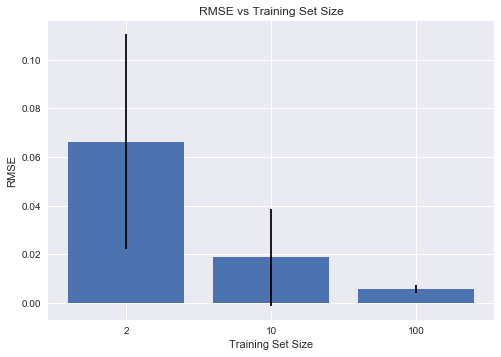

In [15]:
if data_type == 'simulated':
        
    #Plot Agrigate Statistics in the form of a bar graph...
    sizes = list(size_dict.keys())
    means = [np.mean(size_dict[size]) for size in sizes]
    stdevs = [np.std(size_dict[size]) for size in sizes]
    y_pos = np.arange(len(sizes))

    #Calculate Percent Errors              
    #for size in sizes:
    #    for training_set in training_sets:
    #        percent_integrand = lambda t: abs(real_fcn(t) - kinetic_fcn(t))/(real_fcn(t)*max(times))
        
    plt.bar(y_pos, means, align='center',yerr=stdevs)
    plt.xticks(y_pos, sizes)
    plt.ylabel('RMSE')
    plt.xlabel('Training Set Size')
    plt.title('RMSE vs Training Set Size')
    plt.savefig('figures/RMSEvsSize.pdf')
    
    plt.show()

In [105]:
#Perform Analysis to See if Learned Model Can predict the best & Worst producers from 100 strains

def predict_production(modelDict,strain,tsdf):
    #Use Model To figure out production using dynamics
    #print(strain)
    #print(targets)
    #Set Y0 initial condition
    #display(tsdf)
    #y0_targets = pd.MultiIndex.from_tuples([('feature',target) for target in targets])
    strain_df = tsdf.loc[tsdf.index.get_level_values(0) == strain]
    y0 = strain_df.loc[:,tsdf.columns.isin(targets)].iloc[0]
    y0 = y0.reindex(targets).values
    #print('y0',y0)
    
    #Create Differential Equation to Solve
    g = mlode(modelDict, strain_df, targets, specific_features, time_index='Time')

    #Solve Differential Equation numerically using a runge-kutta 4,5 implementation
    times = strain_df.reset_index()['Time'].tolist()
    fit = odeintz(g,y0,times)
    fitT = list(map(list, zip(*fit)))
    
    #print(fitT[-1])
    production = fitT[-1][-1]
    
    #Return Producion at the final time point
    return production

num_trials = 10
if data_type == 'simulated':
    
    strain_numbers = list(test_tsdf.index.get_level_values(0).unique())
    strain_lists = random.sample(strain_numbers,100*num_trials)
    strain_lists = [strain_lists[x:x+100] for x in range(0, len(strain_lists), 100)]
    
    actual_max_ranks = []
    actual_min_ranks = []
    actual_min_productions = []
    actual_max_productions = []
    prediction_errors = []
    for strain_list in strain_lists:
        
        #Sort Chosen Strains by production & Reindex by Rank
        strain_list_index = pd.MultiIndex.from_tuples([(strain,69.0) for strain in strain_list])
        actual_production_df = test_tsdf.loc[test_tsdf.index.isin(strain_list_index),('feature','Limonene')].to_frame()
        actual_production_df.columns = ['Limonene']
        actual_production_df = actual_production_df.sort_values('Limonene',axis=0).reset_index()
        actual_production_df = actual_production_df[['Strain','Limonene']]
        #display(actual_production_df)
        
    
        #Use Model To Predict Production For all Strains
        min_production = float('inf')
        max_production = 0
        display(actual_production_df)
        for strain in strain_list:
            production = predict_production(modelDict,strain,test_df)
            actual_production = actual_production_df.loc[actual_production_df['Strain']==strain,'Limonene'].values[0]
            print(production,actual_production)
            
            #Select Best and Worst Strains
            if production < min_production:
                min_production = production
                actual_min_production = actual_production
                min_strain = strain
                
            if production > max_production:
                max_production = production
                actual_max_production = actual_production
                max_strain = strain
                
            prediction_errors.append(production - actual_production)
            
            print('minimum producing strain ({}) produces {:.4f} g/L'.format(min_strain,min_production))
            print('maximum producing strain ({}) produces {:.4f} g/L'.format(max_strain,max_production))
            
        #Calculate Strain Ranks
        actual_max_ranks.append(actual_production_df.loc[actual_production_df['Strain']==max_strain].index)
        actual_min_ranks.append(actual_production_df.loc[actual_production_df['Strain']==min_strain].index)
        
        #Calculate Predicted Highest Production / Actual Highest Production
        actual_max_productions.append(actual_max_production)
        actual_min_productions.append(actual_min_production)
    

,Strain,Limonene
0,8582,0.009478
1,6282,0.010154
2,5530,0.010675
3,9073,0.012852
4,6068,0.012901
5,5017,0.013065
6,8603,0.013772
7,715,0.013959
8,8194,0.014066
9,8216,0.015097


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0492440449605 0.0482402531034
minimum producing strain (1593) produces 0.0492 g/L
maximum producing strain (1593) produces 0.0492 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0500886245651 0.0489565225848
minimum producing strain (1593) produces 0.0492 g/L
maximum producing strain (3371) produces 0.0501 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0583768715459 0.0572668798855
minimum producing strain (1593) produces 0.0492 g/L
maximum producing strain (9514) produces 0.0584 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0440308447284 0.0431535869523
minimum producing strain (4063) produces 0.0440 g/L
maximum producing strain (9514) produces 0.0584 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-C

0.0382818656652 0.0374307174726
minimum producing strain (6068) produces 0.0177 g/L
maximum producing strain (3787) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0398500124946 0.0391576260329
minimum producing strain (6068) produces 0.0177 g/L
maximum producing strain (3787) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0702331183378 0.0694841468784
minimum producing strain (6068) produces 0.0177 g/L
maximum producing strain (3787) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0358350109699 0.0349959128388
minimum producing strain (6068) produces 0.0177 g/L
maximum producing strain (3787) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0299701710342 0.0281550575885
minimum 

0.0426875193364 0.0417541053235
minimum producing strain (6282) produces 0.0101 g/L
maximum producing strain (3787) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0586176512307 0.0585549654451
minimum producing strain (6282) produces 0.0101 g/L
maximum producing strain (3787) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.011101040461 0.0106754333406
minimum producing strain (6282) produces 0.0101 g/L
maximum producing strain (3787) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0408287200806 0.0398398886448
minimum producing strain (6282) produces 0.0101 g/L
maximum producing strain (3787) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0248420315443 0.0237547935859
minimum p

,Strain,Limonene
0,7613,0.008346
1,5231,0.008972
2,2063,0.009525
3,7861,0.010720
4,6022,0.012264
5,6122,0.013730
6,6947,0.014407
7,2761,0.015545
8,7188,0.018245
9,4423,0.018325


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0138384969175 0.0107201626498
minimum producing strain (7861) produces 0.0138 g/L
maximum producing strain (7861) produces 0.0138 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0280043773286 0.0272714153009
minimum producing strain (7861) produces 0.0138 g/L
maximum producing strain (917) produces 0.0280 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0643170793425 0.0633278827304
minimum producing strain (7861) produces 0.0138 g/L
maximum producing strain (865) produces 0.0643 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0361027192379 0.0344331581293
minimum producing strain (7861) produces 0.0138 g/L
maximum producing strain (865) produces 0.0643 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA'

0.0475764096507 0.046928032295
minimum producing strain (5231) produces 0.0098 g/L
maximum producing strain (8929) produces 0.0680 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0161282708363 0.0122642090309
minimum producing strain (5231) produces 0.0098 g/L
maximum producing strain (8929) produces 0.0680 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0620885139563 0.0611714431131
minimum producing strain (5231) produces 0.0098 g/L
maximum producing strain (8929) produces 0.0680 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0393632656336 0.0386946075715
minimum producing strain (5231) produces 0.0098 g/L
maximum producing strain (8929) produces 0.0680 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0333478630096 0.0327913680908
minimum p

0.0571130804207 0.0558849285374
minimum producing strain (5231) produces 0.0098 g/L
maximum producing strain (6789) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0315976855662 0.0305384858364
minimum producing strain (5231) produces 0.0098 g/L
maximum producing strain (6789) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.067834917429 0.0676034450292
minimum producing strain (5231) produces 0.0098 g/L
maximum producing strain (6789) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0693035624562 0.0682249789957
minimum producing strain (5231) produces 0.0098 g/L
maximum producing strain (6789) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0294602969867 0.0268698078466
minimum p

,Strain,Limonene
0,8429,0.008197
1,9999,0.009215
2,5905,0.009490
3,7603,0.010117
4,6383,0.011580
5,9308,0.011825
6,2860,0.012184
7,1704,0.012860
8,7828,0.013252
9,5644,0.013638


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0703911997723 0.0705966768859
minimum producing strain (6933) produces 0.0704 g/L
maximum producing strain (6933) produces 0.0704 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0495049019719 0.0486019643899
minimum producing strain (7995) produces 0.0495 g/L
maximum producing strain (6933) produces 0.0704 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0390734502417 0.0376393293055
minimum producing strain (6174) produces 0.0391 g/L
maximum producing strain (6933) produces 0.0704 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0257863141222 0.025050908119
minimum producing strain (95) produces 0.0258 g/L
maximum producing strain (6933) produces 0.0704 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA'

0.0301995305447 0.0292331447329
minimum producing strain (7603) produces 0.0097 g/L
maximum producing strain (2322) produces 0.0712 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0171586942271 0.0167616176202
minimum producing strain (7603) produces 0.0097 g/L
maximum producing strain (2322) produces 0.0712 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0482688180409 0.0478008733349
minimum producing strain (7603) produces 0.0097 g/L
maximum producing strain (2322) produces 0.0712 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0476730953752 0.0466630873241
minimum producing strain (7603) produces 0.0097 g/L
maximum producing strain (2322) produces 0.0712 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0590676096617 0.0579781158015
minimum 

0.0254534517258 0.0243573549302
minimum producing strain (8429) produces 0.0094 g/L
maximum producing strain (7745) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0556574282794 0.0550701158819
minimum producing strain (8429) produces 0.0094 g/L
maximum producing strain (7745) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0231953268034 0.0216696878287
minimum producing strain (8429) produces 0.0094 g/L
maximum producing strain (7745) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0439040456123 0.0432820865149
minimum producing strain (8429) produces 0.0094 g/L
maximum producing strain (7745) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0503970859501 0.0502682363392
minimum 

,Strain,Limonene
0,6200,0.007933
1,2756,0.008297
2,1938,0.008890
3,1468,0.010698
4,7999,0.010897
5,7512,0.011040
6,2794,0.011320
7,4911,0.013073
8,1517,0.016384
9,30,0.017052


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0317403146802 0.0301811674611
minimum producing strain (4144) produces 0.0317 g/L
maximum producing strain (4144) produces 0.0317 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.00934206281506 0.00829668032289
minimum producing strain (2756) produces 0.0093 g/L
maximum producing strain (4144) produces 0.0317 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0299215537086 0.0289992020824
minimum producing strain (2756) produces 0.0093 g/L
maximum producing strain (4144) produces 0.0317 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0113372449869 0.00793308077504
minimum producing strain (2756) produces 0.0093 g/L
maximum producing strain (4144) produces 0.0317 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HM

0.0284608193525 0.0280569816963
minimum producing strain (1938) produces 0.0090 g/L
maximum producing strain (4215) produces 0.0709 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0533098071783 0.0528093000687
minimum producing strain (1938) produces 0.0090 g/L
maximum producing strain (4215) produces 0.0709 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0698742614966 0.0698568598628
minimum producing strain (1938) produces 0.0090 g/L
maximum producing strain (4215) produces 0.0709 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.049234454859 0.0481154235618
minimum producing strain (1938) produces 0.0090 g/L
maximum producing strain (4215) produces 0.0709 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0650763068596 0.0645641187871
minimum p

0.0207154357356 0.0163838925149
minimum producing strain (1938) produces 0.0090 g/L
maximum producing strain (4215) produces 0.0709 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0231521213216 0.0205900455841
minimum producing strain (1938) produces 0.0090 g/L
maximum producing strain (4215) produces 0.0709 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0423952946861 0.0406583495916
minimum producing strain (1938) produces 0.0090 g/L
maximum producing strain (4215) produces 0.0709 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.05367393397 0.0529492745449
minimum producing strain (1938) produces 0.0090 g/L
maximum producing strain (4215) produces 0.0709 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0371930589456 0.0359169896423
minimum pr

,Strain,Limonene
0,6044,0.010178
1,3596,0.011202
2,5834,0.011225
3,5404,0.011245
4,9752,0.011456
5,1482,0.011753
6,4854,0.011883
7,7705,0.012869
8,9281,0.013069
9,6649,0.013885


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0248171196212 0.0242996358537
minimum producing strain (1540) produces 0.0248 g/L
maximum producing strain (1540) produces 0.0248 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0335045633757 0.0330984033279
minimum producing strain (1540) produces 0.0248 g/L
maximum producing strain (8240) produces 0.0335 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0594853492832 0.0580998353274
minimum producing strain (1540) produces 0.0248 g/L
maximum producing strain (2037) produces 0.0595 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0385206035774 0.0378661920778
minimum producing strain (1540) produces 0.0248 g/L
maximum producing strain (2037) produces 0.0595 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-C

0.0639481739464 0.0628192914264
minimum producing strain (3596) produces 0.0107 g/L
maximum producing strain (3777) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0678107501963 0.0667136325929
minimum producing strain (3596) produces 0.0107 g/L
maximum producing strain (3777) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0648068124399 0.0633821652043
minimum producing strain (3596) produces 0.0107 g/L
maximum producing strain (3777) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0432803842263 0.0430005468498
minimum producing strain (3596) produces 0.0107 g/L
maximum producing strain (3777) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0232290672506 0.0185993222708
minimum 

0.067668708786 0.0666803120073
minimum producing strain (3596) produces 0.0107 g/L
maximum producing strain (3777) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0506086411978 0.0497187623541
minimum producing strain (3596) produces 0.0107 g/L
maximum producing strain (3777) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0234794673118 0.022047715912
minimum producing strain (3596) produces 0.0107 g/L
maximum producing strain (3777) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0391065056926 0.037931793688
minimum producing strain (3596) produces 0.0107 g/L
maximum producing strain (3777) produces 0.0728 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0196387600078 0.0189465085578
minimum pro

,Strain,Limonene
0,8776,0.008652
1,3876,0.009006
2,9665,0.009714
3,7818,0.010161
4,3978,0.011712
5,9069,0.012243
6,1108,0.013253
7,3794,0.014000
8,1634,0.014853
9,1902,0.015495


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0228003647318 0.019556754227
minimum producing strain (4470) produces 0.0228 g/L
maximum producing strain (4470) produces 0.0228 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0518748508953 0.0509270713615
minimum producing strain (4470) produces 0.0228 g/L
maximum producing strain (1013) produces 0.0519 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0101324733714 0.00971380220443
minimum producing strain (9665) produces 0.0101 g/L
maximum producing strain (1013) produces 0.0519 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0555517037256 0.0563099288742
minimum producing strain (9665) produces 0.0101 g/L
maximum producing strain (3323) produces 0.0556 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-C

0.0226080873137 0.0175705139196
minimum producing strain (9665) produces 0.0101 g/L
maximum producing strain (1621) produces 0.0669 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0579013181308 0.0569183411307
minimum producing strain (9665) produces 0.0101 g/L
maximum producing strain (1621) produces 0.0669 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.063834969691 0.0620212881671
minimum producing strain (9665) produces 0.0101 g/L
maximum producing strain (1621) produces 0.0669 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0324307240616 0.0311559220336
minimum producing strain (9665) produces 0.0101 g/L
maximum producing strain (1621) produces 0.0669 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0475198940678 0.0460738118363
minimum p

0.0171271812022 0.0159396626779
minimum producing strain (3876) produces 0.0095 g/L
maximum producing strain (8468) produces 0.0696 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0476186573057 0.0461092995742
minimum producing strain (3876) produces 0.0095 g/L
maximum producing strain (8468) produces 0.0696 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.024092653923 0.0227542911631
minimum producing strain (3876) produces 0.0095 g/L
maximum producing strain (8468) produces 0.0696 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0403807175581 0.0393981680163
minimum producing strain (3876) produces 0.0095 g/L
maximum producing strain (8468) produces 0.0696 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0623388478023 0.0614347439816
minimum p

,Strain,Limonene
0,1497,0.009846
1,1157,0.010611
2,3666,0.011490
3,9612,0.011671
4,9282,0.012376
5,8454,0.012735
6,2114,0.013572
7,4094,0.014859
8,1519,0.014928
9,936,0.016235


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0377952463818 0.0365191181625
minimum producing strain (2146) produces 0.0378 g/L
maximum producing strain (2146) produces 0.0378 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0487785706722 0.0486258568596
minimum producing strain (2146) produces 0.0378 g/L
maximum producing strain (3137) produces 0.0488 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0604468118639 0.0597891812282
minimum producing strain (2146) produces 0.0378 g/L
maximum producing strain (3617) produces 0.0604 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0326652993538 0.0285990993358
minimum producing strain (6759) produces 0.0327 g/L
maximum producing strain (3617) produces 0.0604 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-C

0.0544606547927 0.0527669376174
minimum producing strain (8454) produces 0.0141 g/L
maximum producing strain (431) produces 0.0699 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0221086550839 0.0188393459069
minimum producing strain (8454) produces 0.0141 g/L
maximum producing strain (431) produces 0.0699 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.038472889925 0.037039789269
minimum producing strain (8454) produces 0.0141 g/L
maximum producing strain (431) produces 0.0699 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0126283103985 0.00984605751489
minimum producing strain (1497) produces 0.0126 g/L
maximum producing strain (431) produces 0.0699 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0649111922262 0.0637332235081
minimum produ

0.0399544848692 0.0387146719008
minimum producing strain (1497) produces 0.0126 g/L
maximum producing strain (4862) produces 0.0718 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0394543269389 0.0387234279489
minimum producing strain (1497) produces 0.0126 g/L
maximum producing strain (4862) produces 0.0718 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0551105562892 0.0538153180778
minimum producing strain (1497) produces 0.0126 g/L
maximum producing strain (4862) produces 0.0718 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0267071544698 0.0261081600247
minimum producing strain (1497) produces 0.0126 g/L
maximum producing strain (4862) produces 0.0718 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0412043104432 0.040070890013
minimum p

,Strain,Limonene
0,7682,0.008275
1,1838,0.009366
2,2678,0.009479
3,9626,0.009537
4,45,0.010213
5,7626,0.011114
6,9561,0.011964
7,2961,0.013015
8,9544,0.014488
9,5161,0.014595


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0360067420738 0.0340233513936
minimum producing strain (8481) produces 0.0360 g/L
maximum producing strain (8481) produces 0.0360 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0221305005923 0.014594858737
minimum producing strain (5161) produces 0.0221 g/L
maximum producing strain (8481) produces 0.0360 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0613789265751 0.061682407264
minimum producing strain (5161) produces 0.0221 g/L
maximum producing strain (4785) produces 0.0614 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0219781724519 0.0212526051245
minimum producing strain (4155) produces 0.0220 g/L
maximum producing strain (4785) produces 0.0614 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA

0.0412700697683 0.0418313870478
minimum producing strain (9626) produces 0.0092 g/L
maximum producing strain (4984) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0301664956155 0.0299360611581
minimum producing strain (9626) produces 0.0092 g/L
maximum producing strain (4984) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0464349277593 0.0456533127628
minimum producing strain (9626) produces 0.0092 g/L
maximum producing strain (4984) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0686422289238 0.0684407706496
minimum producing strain (9626) produces 0.0092 g/L
maximum producing strain (4984) produces 0.0705 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0690745923741 0.0675248637254
minimum 

0.00905461337939 0.0082751349368
minimum producing strain (7682) produces 0.0091 g/L
maximum producing strain (750) produces 0.0734 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0635173366551 0.0625985469331
minimum producing strain (7682) produces 0.0091 g/L
maximum producing strain (750) produces 0.0734 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0561614400376 0.054948748476
minimum producing strain (7682) produces 0.0091 g/L
maximum producing strain (750) produces 0.0734 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0709509106136 0.0703953256723
minimum producing strain (7682) produces 0.0091 g/L
maximum producing strain (750) produces 0.0734 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0460531947549 0.0452120853688
minimum prod

,Strain,Limonene
0,5686,0.008799
1,730,0.009366
2,3930,0.009578
3,4848,0.010071
4,1455,0.010670
5,9972,0.010900
6,5806,0.014463
7,2799,0.014813
8,4767,0.015576
9,5420,0.018346


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0432149751188 0.04252564726
minimum producing strain (9918) produces 0.0432 g/L
maximum producing strain (9918) produces 0.0432 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0578153867076 0.0573575186079
minimum producing strain (9918) produces 0.0432 g/L
maximum producing strain (3797) produces 0.0578 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0655359926242 0.0646764959133
minimum producing strain (9918) produces 0.0432 g/L
maximum producing strain (1635) produces 0.0655 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0234343550556 0.0230745705316
minimum producing strain (5146) produces 0.0234 g/L
maximum producing strain (1635) produces 0.0655 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA

0.056346459077 0.0554329567206
minimum producing strain (3930) produces 0.0098 g/L
maximum producing strain (9844) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0626887645568 0.0616760699087
minimum producing strain (3930) produces 0.0098 g/L
maximum producing strain (9844) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0474128220897 0.0470663969913
minimum producing strain (3930) produces 0.0098 g/L
maximum producing strain (9844) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0572472229041 0.0559081074254
minimum producing strain (3930) produces 0.0098 g/L
maximum producing strain (9844) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0657525006035 0.0650113014853
minimum p

0.0399326525627 0.0387345425108
minimum producing strain (4848) produces 0.0092 g/L
maximum producing strain (9844) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0355632853897 0.0340765246724
minimum producing strain (4848) produces 0.0092 g/L
maximum producing strain (9844) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0314671273169 0.0309503555507
minimum producing strain (4848) produces 0.0092 g/L
maximum producing strain (9844) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0549729929515 0.0539772204063
minimum producing strain (4848) produces 0.0092 g/L
maximum producing strain (9844) produces 0.0727 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0290649950483 0.0277700980234
minimum 

,Strain,Limonene
0,2610,0.007751
1,3820,0.007998
2,1710,0.008253
3,2026,0.008865
4,541,0.009943
5,7994,0.010331
6,8992,0.010336
7,4973,0.010842
8,8546,0.010879
9,3866,0.011964


['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0243405347616 0.0234131729307
minimum producing strain (407) produces 0.0243 g/L
maximum producing strain (407) produces 0.0243 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0617205169913 0.0612791498301
minimum producing strain (407) produces 0.0243 g/L
maximum producing strain (1018) produces 0.0617 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0137040474439 0.0119637845732
minimum producing strain (3866) produces 0.0137 g/L
maximum producing strain (1018) produces 0.0617 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0314235789813 0.0303773561934
minimum producing strain (3866) produces 0.0137 g/L
maximum producing strain (1018) produces 0.0617 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA'

0.0566288286501 0.0554396918908
minimum producing strain (3866) produces 0.0137 g/L
maximum producing strain (8867) produces 0.0730 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0575821940153 0.0562126329542
minimum producing strain (3866) produces 0.0137 g/L
maximum producing strain (8867) produces 0.0730 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0326444005267 0.0290662333783
minimum producing strain (3866) produces 0.0137 g/L
maximum producing strain (8867) produces 0.0730 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0225232744315 0.0079979738147
minimum producing strain (3866) produces 0.0137 g/L
maximum producing strain (8867) produces 0.0730 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.061368812582 0.0609569727895
minimum p

0.0200496730699 0.0108789518486
minimum producing strain (2026) produces 0.0095 g/L
maximum producing strain (8867) produces 0.0730 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0226244834848 0.0202786433313
minimum producing strain (2026) produces 0.0095 g/L
maximum producing strain (8867) produces 0.0730 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0686271316163 0.0667103536566
minimum producing strain (2026) produces 0.0095 g/L
maximum producing strain (8867) produces 0.0730 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0206136237793 0.0202530519162
minimum producing strain (2026) produces 0.0095 g/L
maximum producing strain (8867) produces 0.0730 g/L
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
0.0699748553606 0.0687123333718
minimum 

99.9 0.3
2.1 0.943398113206
0.00271761104967
95% of all predicted strain productivities are within 2.72 mg/L Limonene.


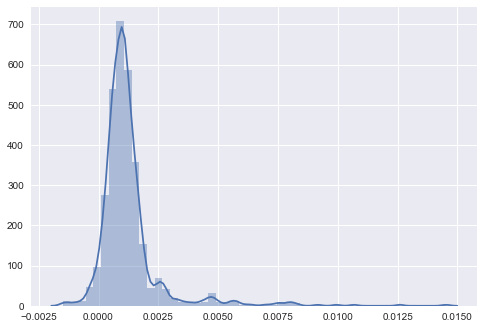

In [121]:
#Plot all findings from Production Prediction Experiment!
if data_type == 'simulated':
    #Plot Average Rank Predicted for Min / Max Strains (And Compute/ Present Statistics)
    print(np.mean(actual_max_ranks)+1,np.std(actual_max_ranks))
    print(np.mean(actual_min_ranks)+1,np.std(actual_min_ranks))
    
    #plt.bar()
    
    
    #Plot Predicted Max vs Actual Max for each Set
    #plt.scatter(actual_max_productions,actual_min_productions)
    #plt.show()
    
    #Plot Production Error histogram (And Compute/Present Statistics)
    print('95% of all predicted strain productivities are within {:.2f} mg/L Limonene.'.format(np.std(prediction_errors)*2*1000))
    sns.distplot(prediction_errors)
    plt.show()
    